## ReMKiT1D input generator - Gaussian advection test

This notebook generates the advection test without using any common models to demonstrate how terms and models are constructed from scratch on a simple example. It also demonstrates the tree-based derivation.

For a more detailed example see the ReMKiT1D_custom_fluid notebook.

This notebook corresponds to Sections 3.2. and 5.1.1. of the ReMKiT1D code paper.

In [1]:
import sys
sys.path.append('../')
from RMK_support import RKWrapper ,Grid ,Node ,treeDerivation
import RMK_support.simple_containers as sc
import RMK_support.IO_support as io

import numpy as np
import holoviews as hv
import matplotlib.pyplot as plt

### Wrapper initialization


In [2]:
rk = RKWrapper()

### Global parameters for writing the files


In [3]:
rk.jsonFilepath = "./config.json" # Default value
hdf5Filepath = "./RMKOutput/RMK_advection_test/"
rk.setHDF5Path(hdf5Filepath) # The input and output location of any HDF5 files used/generated by the code

### Setting options for external libraries used by ReMKiT1D


#### MPI


In [4]:
numProcsX = 4 # Number of processes in x direction
numProcsH = 1 # Number of processes in harmonic direction 
haloWidth = 1 # Halo width in cells 
numProcs = numProcsH * numProcsX
rk.setMPIData(numProcsX,numProcsH,haloWidth)

### Normalization


In [5]:
rk.setNormDensity(1.0e19) #n_0
rk.setNormTemperature(10.0) #T_0
rk.setNormRefZ(1.0) # reference ion charge for e-i collision time

### Grid initialization


In [6]:
# In normalized length or in meters - defaults to normalized unless isLengthInMeters=True in Grid
xGridWidths = 0.025*np.ones(512)
# In normalized velocity - default normalization is thermal velocity sqrt(m_e * k * T_e/2)
vGrid = np.ones(1) 
lMax = 0
gridObj = Grid(xGridWidths, vGrid, lMax, interpretXGridAsWidths=True)

rk.grid = gridObj

### Variable container


#### Adding variables


In [7]:
n = 1 + np.exp(-(gridObj.xGrid-np.mean(gridObj.xGrid))**2) # A Gaussian perturbation
T = np.ones(len(gridObj.xGrid)) # Constant temperature

# These will add both the variable 'v' and 'v_dual'
rk.addVarAndDual('n',n,isCommunicated=True) 
rk.addVar('T',T,isDerived=True) # isDerived removes the variable from the implicit vector
rk.addVarAndDual('u',isCommunicated=True,primaryOnDualGrid=True) # primaryOnDualGrid denotes that the main variable is u_dual, and u is interpolated 
rk.addVar('time',isDerived=True,isScalar=True)

In [8]:
#Tree based calculation example
nNode = Node('n')
uNode = Node('u')
TNode = Node('T')

massRatio = 1/1836

wNode = 1.5*nNode*TNode + uNode**2/(nNode*massRatio) # assuming normalization to n_0*e*T_0

In [9]:
rk.addCustomDerivation("wDeriv",treeDerivation(wNode)) # Registering the derivation in the wrapper

In [10]:
rk.addVar("W",isDerived=True,derivationRule=sc.derivationRule("wDeriv",['n','u','T'])) # the derivation rule states which variables W depends on

### Models 

$\frac{\partial n}{\partial t} = - \frac{\partial u}{\partial x}$

$m_i \frac{\partial u}{\partial t} = - \frac{\partial (nkT)}{\partial x}$


In [11]:
# adding the div(u) term to the n equation
newModel = sc.CustomModel(modelTag="nAdvection")

# the implicit variable is 'u_dual' since it is the primary variable 
# and the stencil is staggered because 'n' and 'u_dual' live on different grids
divFluxTerm = sc.GeneralMatrixTerm(evolvedVar='n',implicitVar='u_dual',customNormConst=-1.0,stencilData=sc.staggeredDivStencil())
newModel.addTerm("divFlux",divFluxTerm)
rk.addModel(newModel.dict())



In [12]:

# adding the pressure gradient term to the u_dual equation
newModel = sc.CustomModel(modelTag='pGrad')
#Required variable data for pressure 
vData = sc.VarData(reqColVars=['T']) 

# the normalization constant comes from the fact that velocity/speed are normalized so that m_e*v**2/2 = k*T_0
gradTerm = sc.GeneralMatrixTerm(evolvedVar='u_dual',implicitVar='n',customNormConst=-massRatio/2,stencilData=sc.staggeredGradStencil(),varData=vData)

newModel.addTerm("gradTerm",gradTerm)
rk.addModel(newModel.dict())

### Integrator options


In [13]:
# the implicit BDE integrator that checks convergence based on the variables 'n' and 'u_dual'
integrator = sc.picardBDEIntegrator(nonlinTol=1e-12,absTol=10.0,convergenceVars=['n','u_dual']) 

rk.addIntegrator("BE",integrator)

#### Global integrator options and timestep control

In [14]:
# fixed timestep in this example
initialTimestep=0.1 # in normalized time units
rk.setIntegratorGlobalData(1, # number of allowed implicit term groups - grouping everything into one group per model
                           1, # number of allowed general term groups
                           initialTimestep) 

#### Controlling integration steps

In [15]:
# a single integration step evolving all models
bdeStep = sc.IntegrationStep("BE")

for tag in rk.modelTags():
    bdeStep.addModel(tag)

rk.addIntegrationStep("StepBDE",bdeStep.dict())

### Time loop options

In [16]:
rk.setFixedNumTimesteps(10000)
rk.setFixedStepOutput(200)

### Create config file

In [17]:
rk.writeConfigFile()

### Set global plotting options

In [18]:
hv.extension('matplotlib')
%matplotlib inline 
plt.rcParams['figure.dpi'] = 150
hv.output(size=150,dpi=150)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

### Load data from ReMKiT1D output files

In [19]:
numFiles = 50
loadpath = hdf5Filepath
loadFilenames = [loadpath+f'ReMKiT1DVarOutput_{i}.h5' for i in range(numFiles+1)]
loadedData = io.loadFromHDF5(rk.varCont,filepaths=loadFilenames)
loadedData

<xarray.Dataset>
Dimensions:  (x: 512, h: 1, v: 1, time: 51)
Coordinates:
  * x        (x) float64 0.0125 0.0375 0.0625 0.0875 ... 12.71 12.74 12.76 12.79
  * h        (h) int64 0
  * v        (v) float64 1.0
  * time     (time) float64 0.0 20.0 40.0 60.0 80.0 ... 940.0 960.0 980.0 1e+03
Data variables:
    n        (time, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.001 1.001 1.001
    n_dual   (time, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.001 1.001 1.001 1.001
    T        (time, x) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    u_dual   (time, x) float64 0.0 0.0 0.0 0.0 ... 4.228e-06 2.101e-06 0.0
    u        (time, x) float64 0.0 0.0 0.0 0.0 ... 5.317e-06 3.164e-06 1.037e-06
    W        (time, x) float64 1.5 1.5 1.5 1.5 1.5 ... 1.502 1.502 1.502 1.502

### Compare with analytic solution

In [20]:
wave_speed= np.sqrt(massRatio/2)
n_analytic=np.zeros((numFiles+1,gridObj.numX()))
times = loadedData.coords['time'].data
L = sum(xGridWidths)
for i in range(numFiles+1):
        leftPositionMod = (gridObj.xGrid-wave_speed*times[i]) % L
        leftPosition = np.where(leftPositionMod > 0,leftPositionMod,leftPositionMod+L)
        rightPosition = (gridObj.xGrid+wave_speed*times[i]) % L
        n_analytic[i,:] =1 + 0.5*(np.exp(-(leftPosition-np.mean(gridObj.xGrid))**2) + np.exp(-(rightPosition-np.mean(gridObj.xGrid))**2)) 


:HoloMap   [time]
   :Overlay
      .Scatter.Simulation    :Scatter   [x]   (n)
      .Curve.Analytic_result :Curve   [x]   (y)
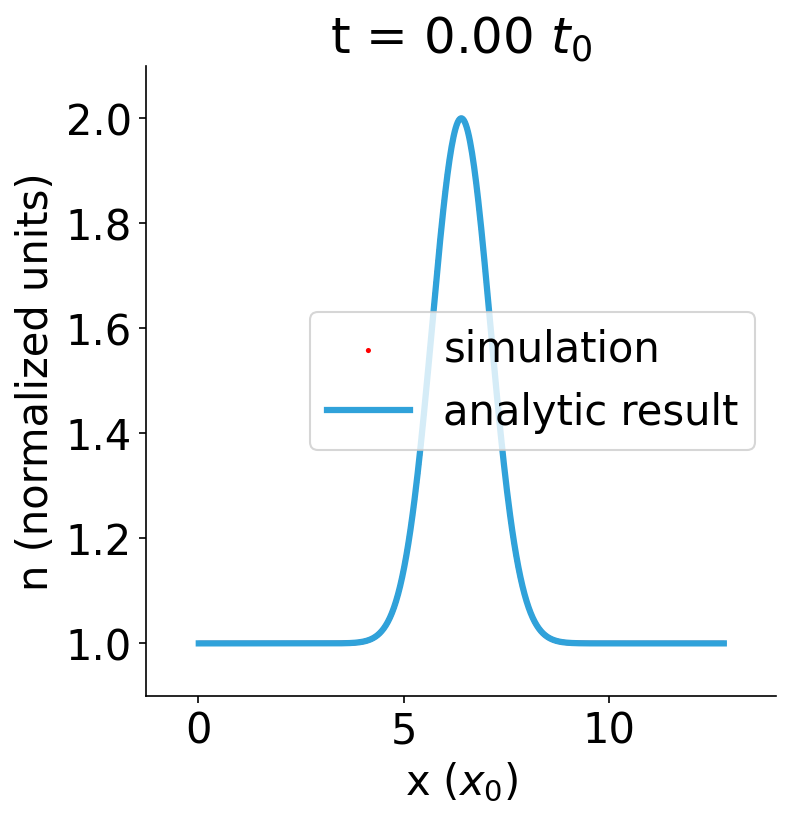
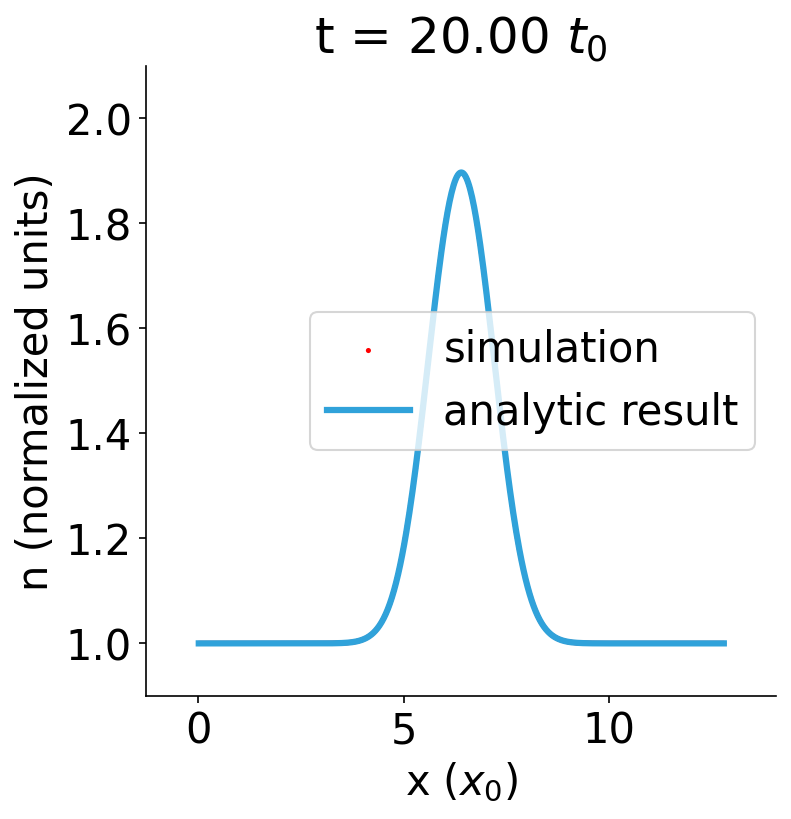
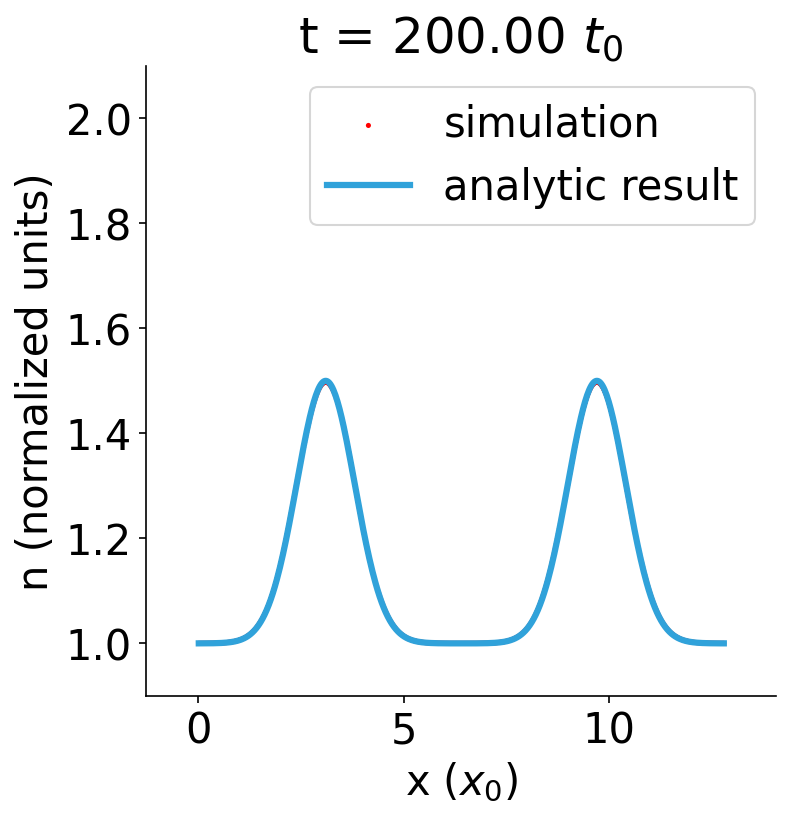
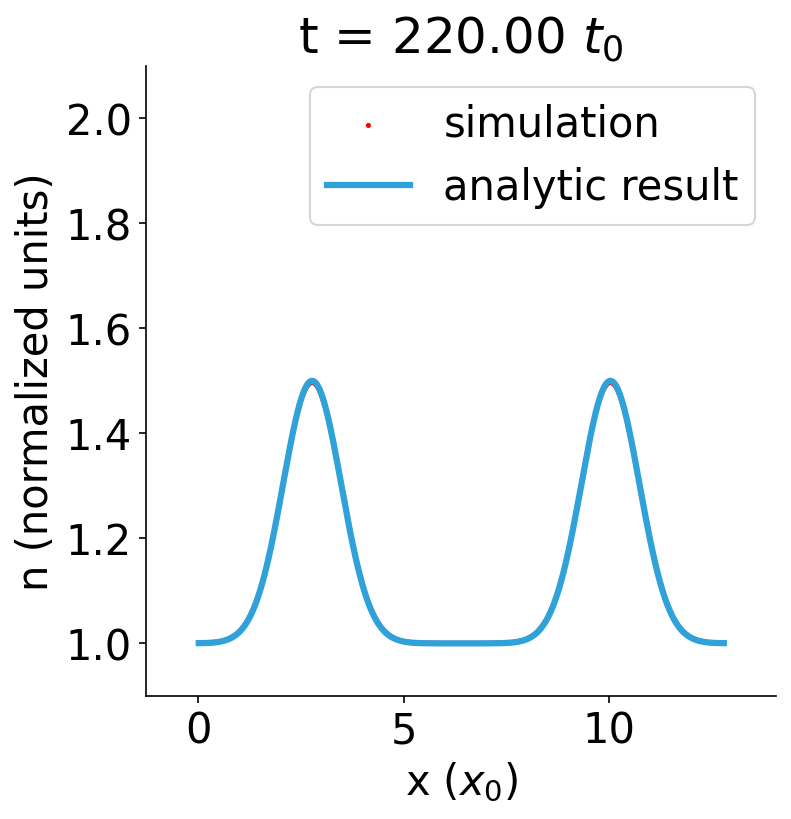
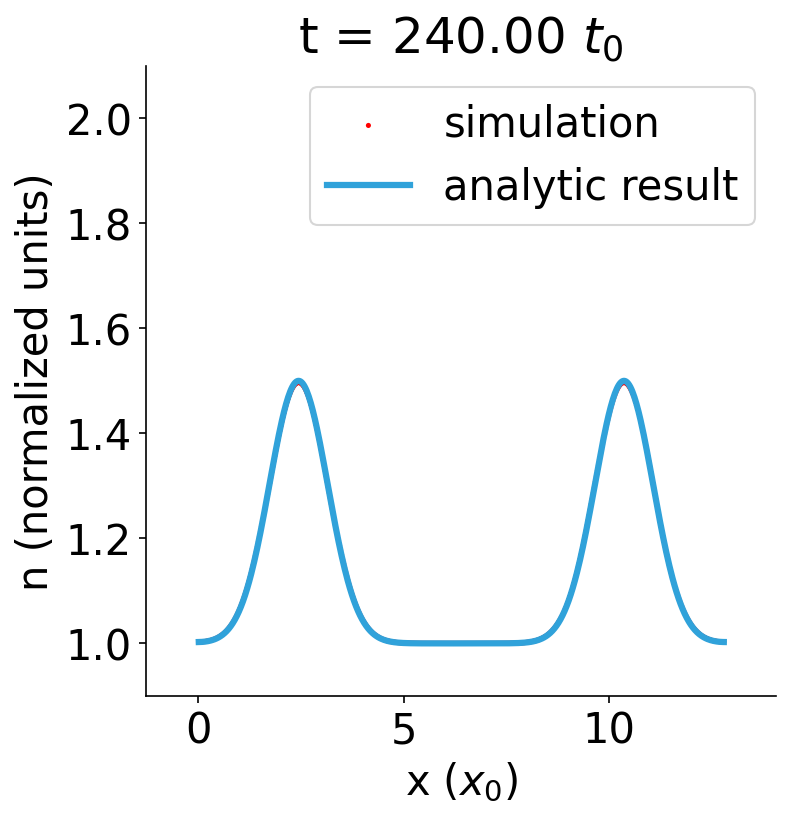
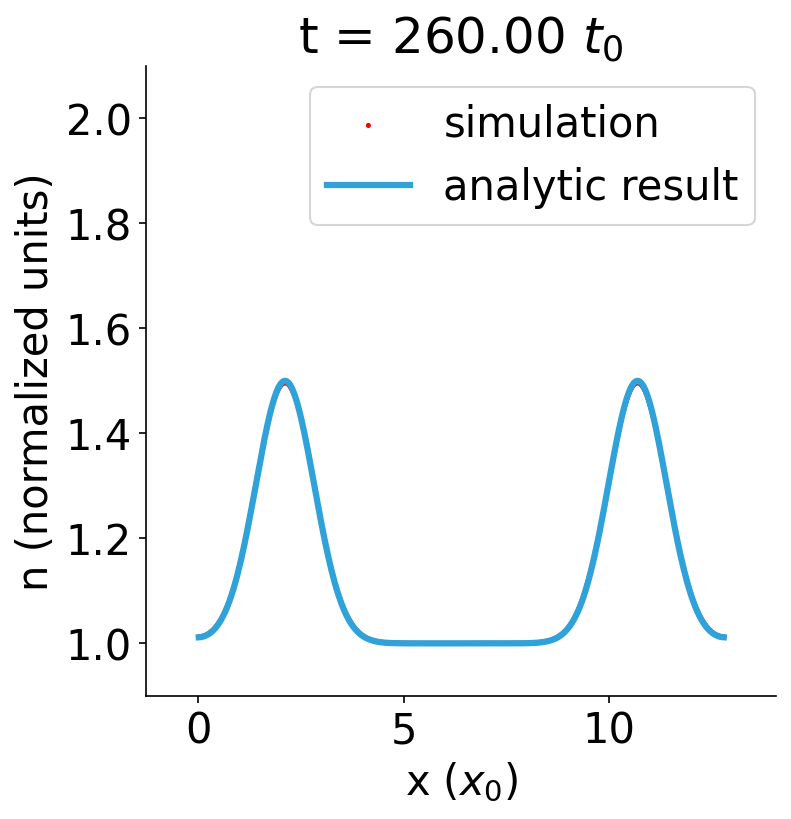
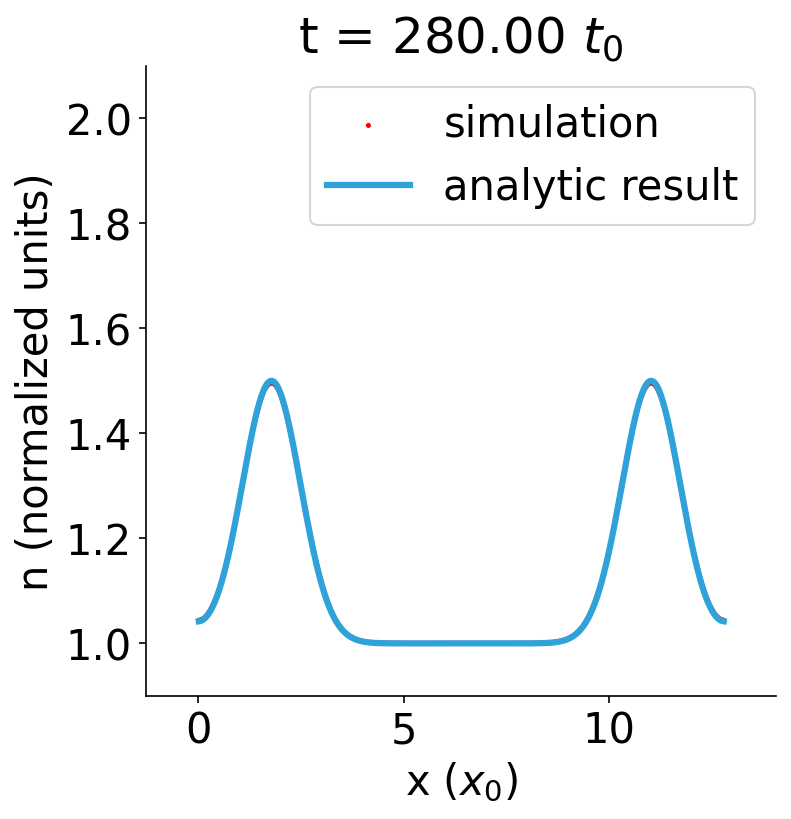
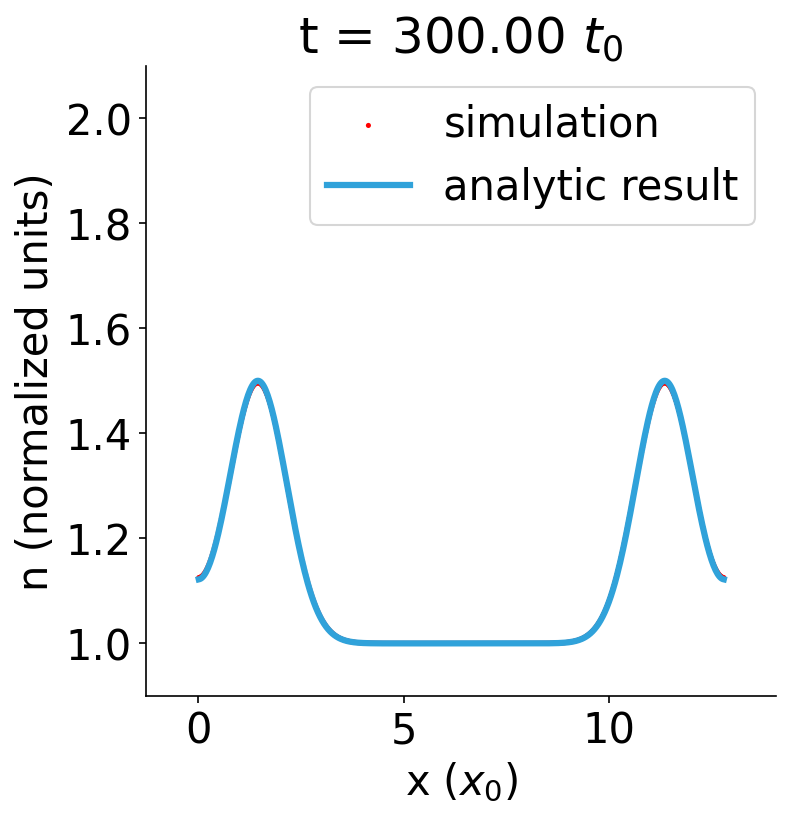
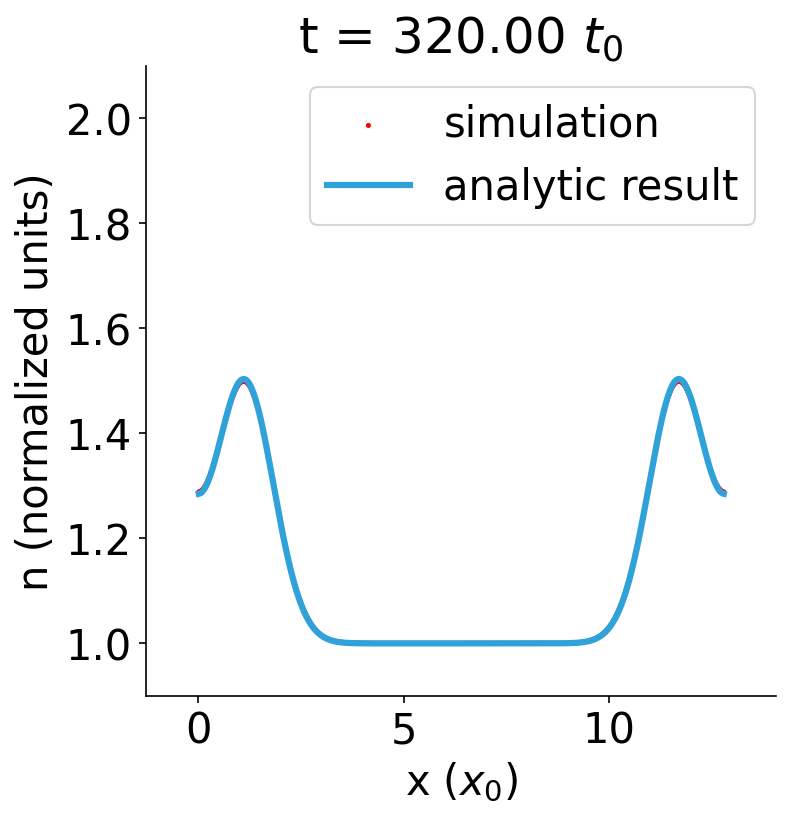
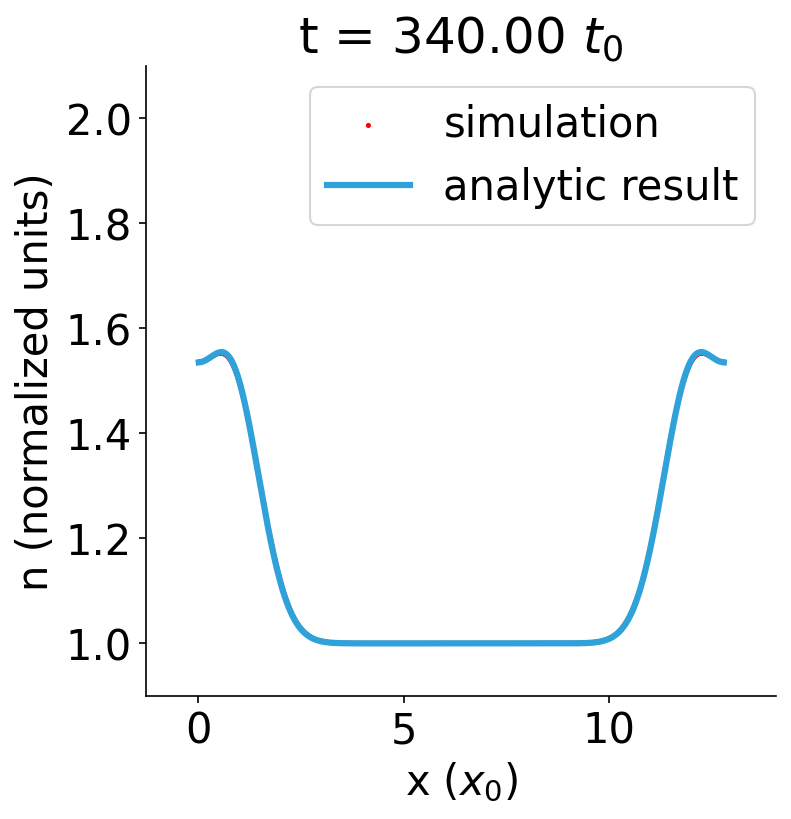
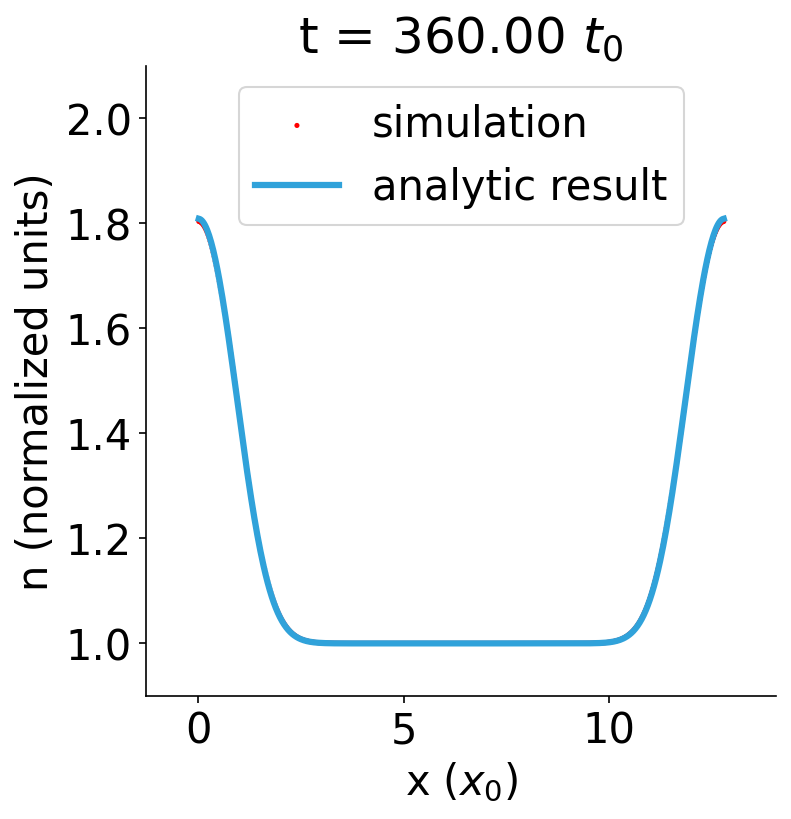
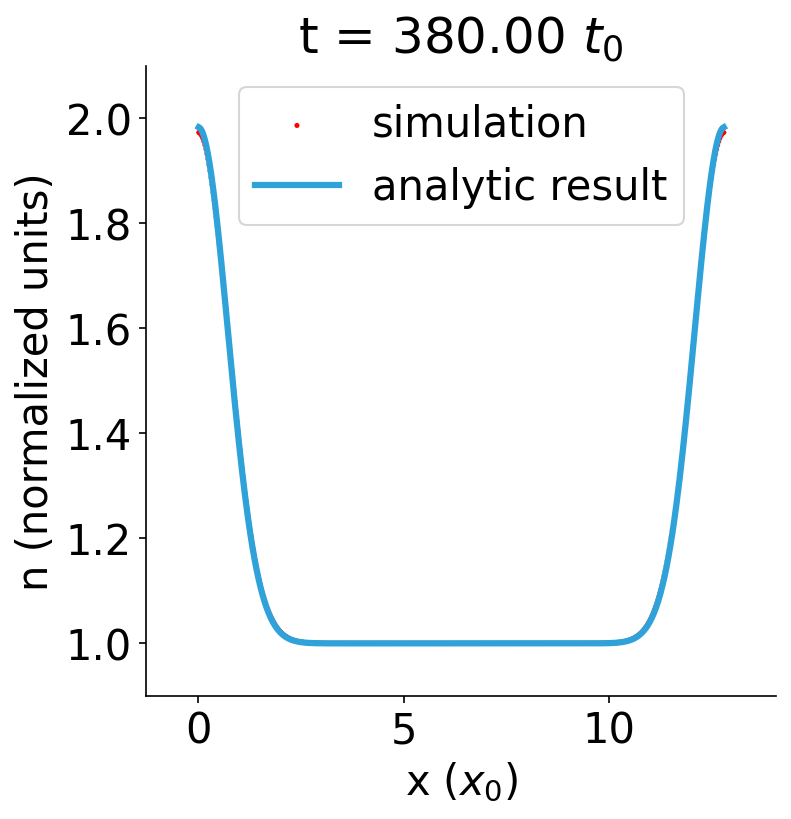
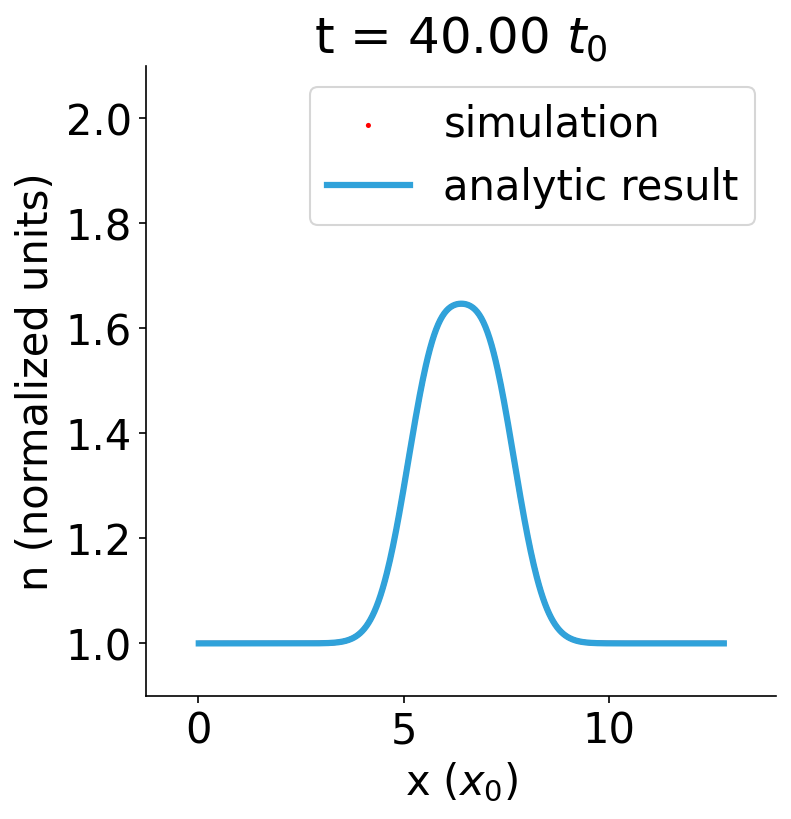
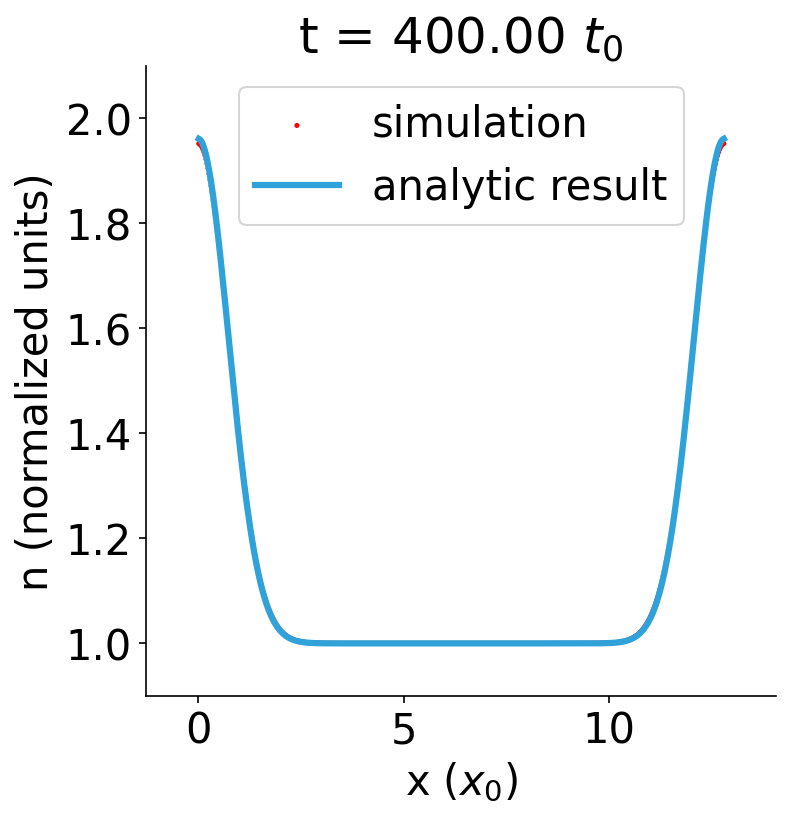
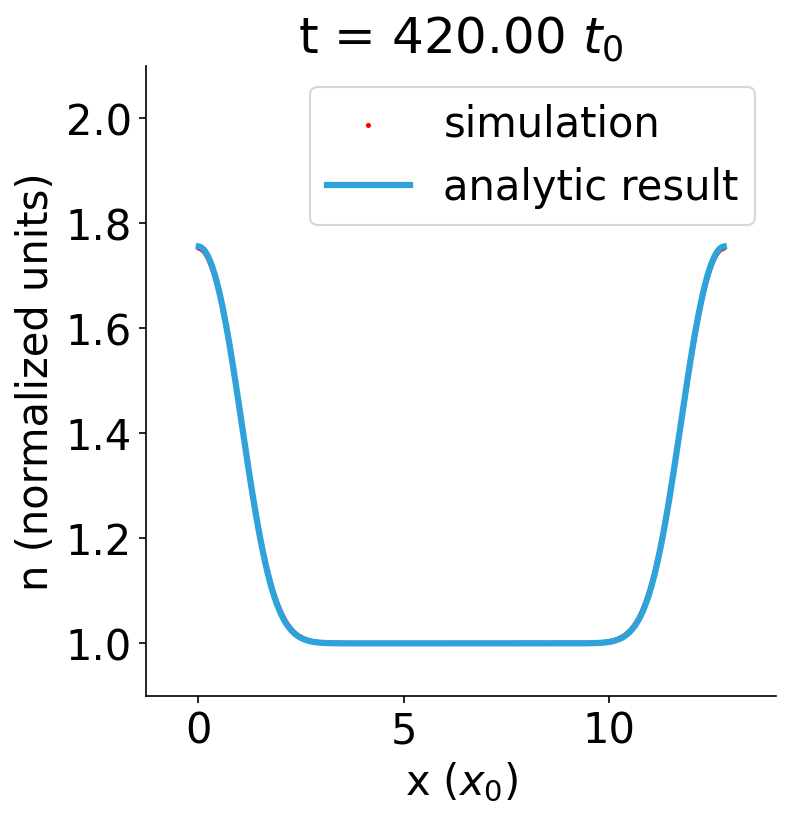
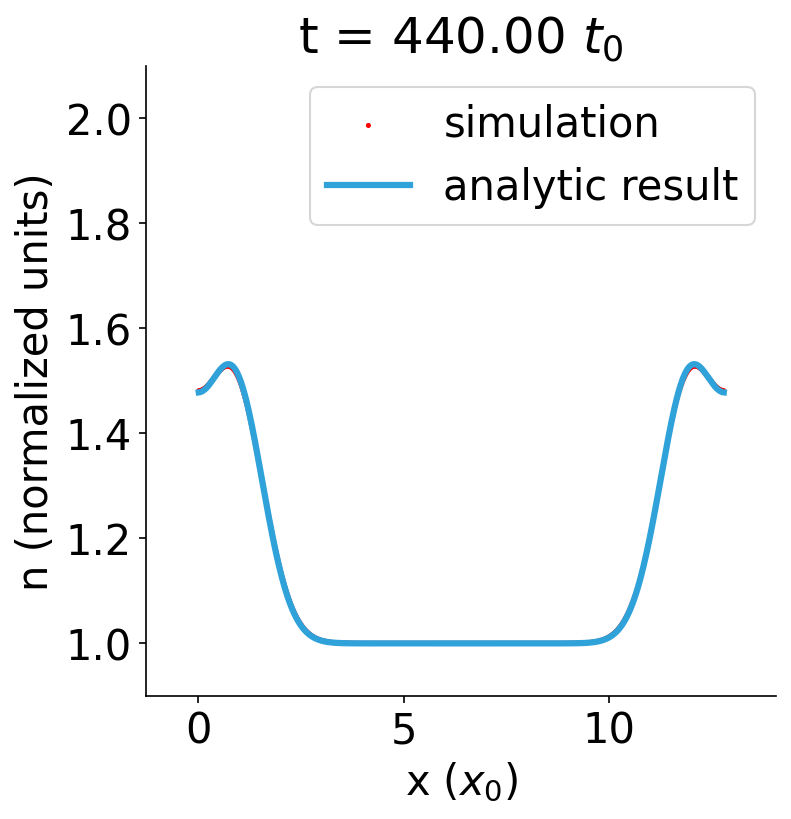
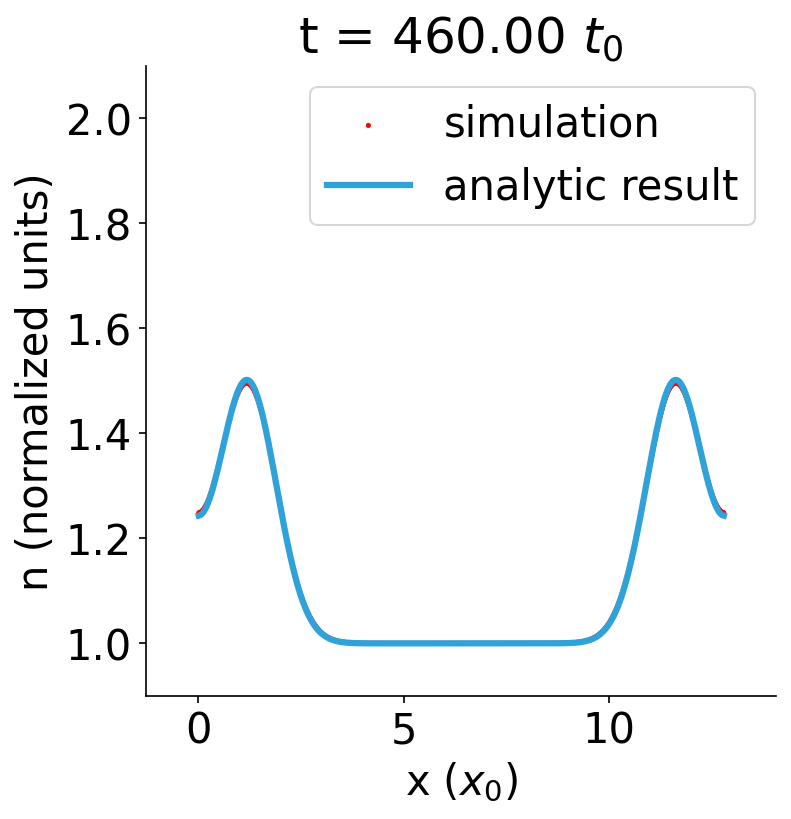
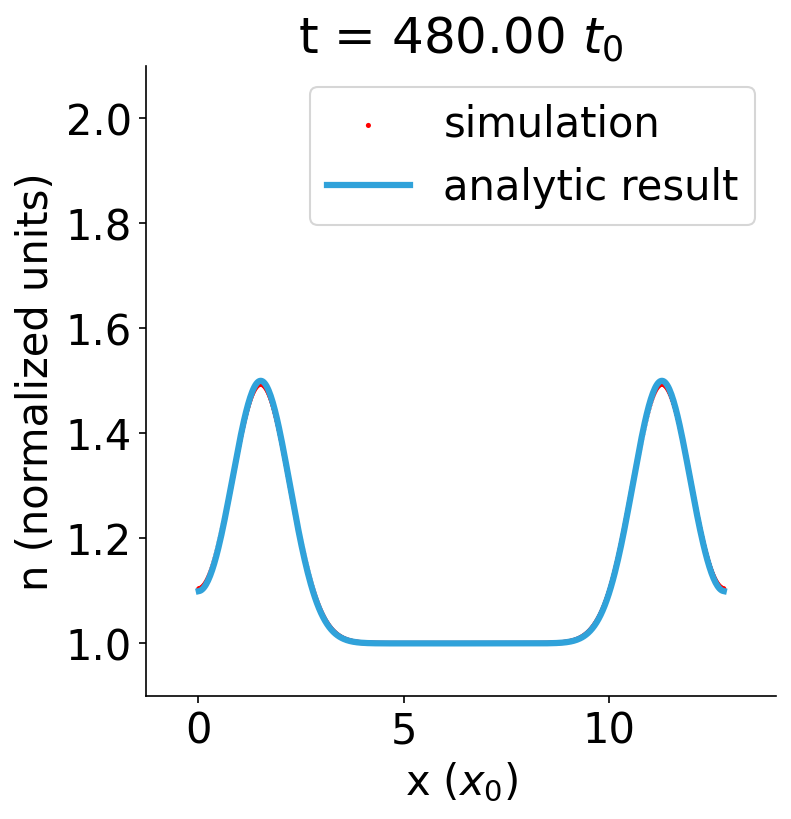
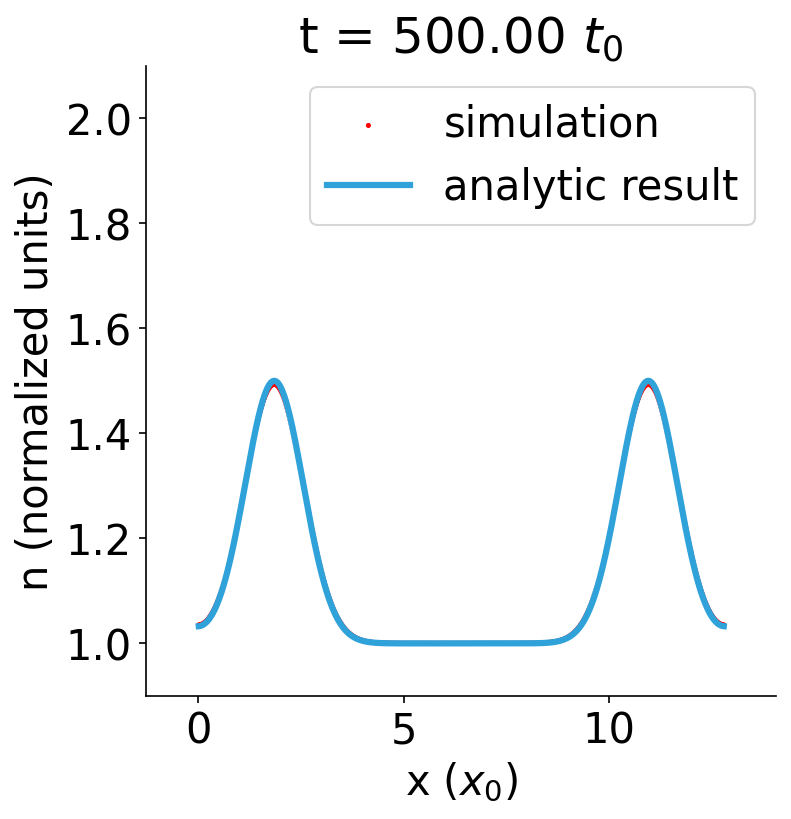
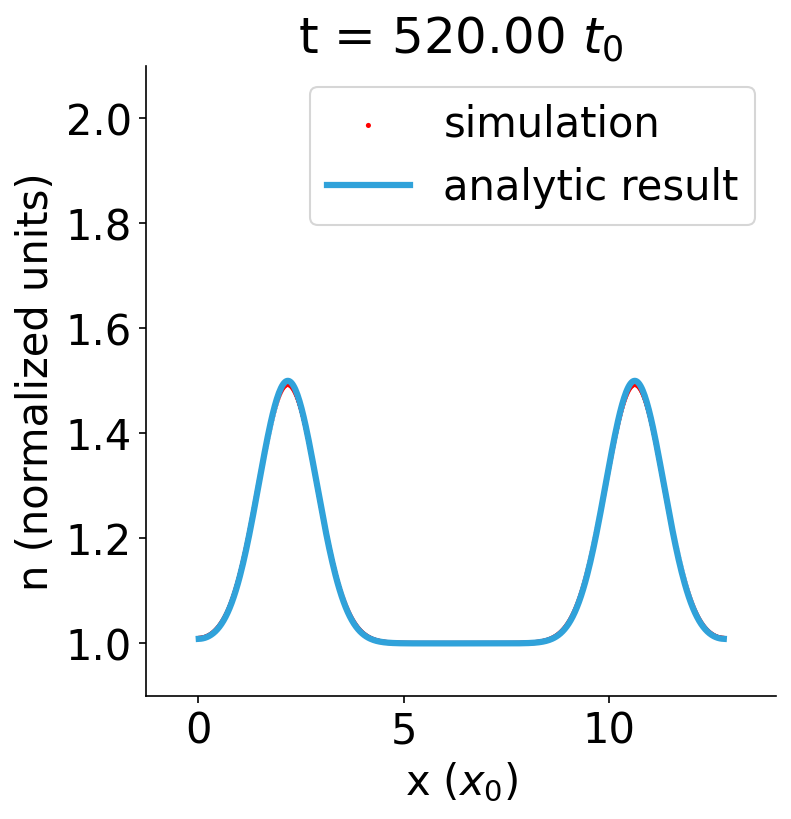
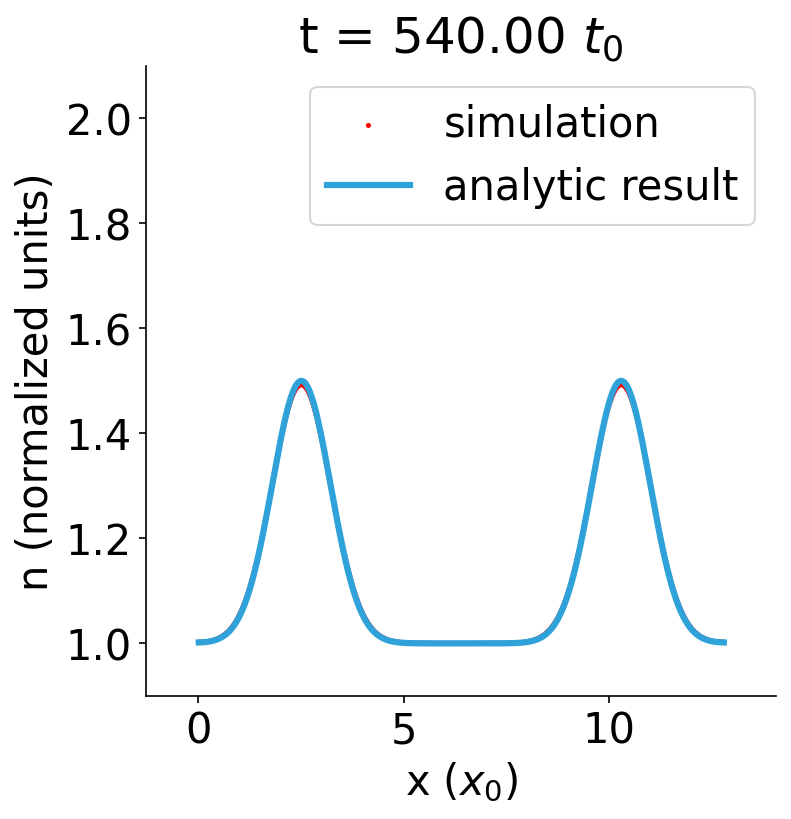
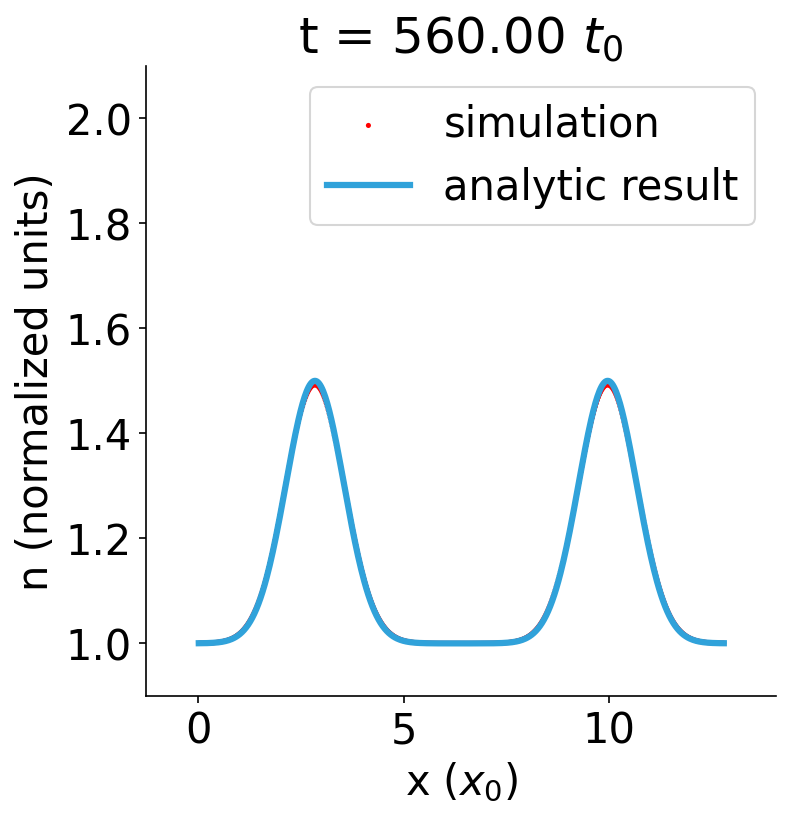
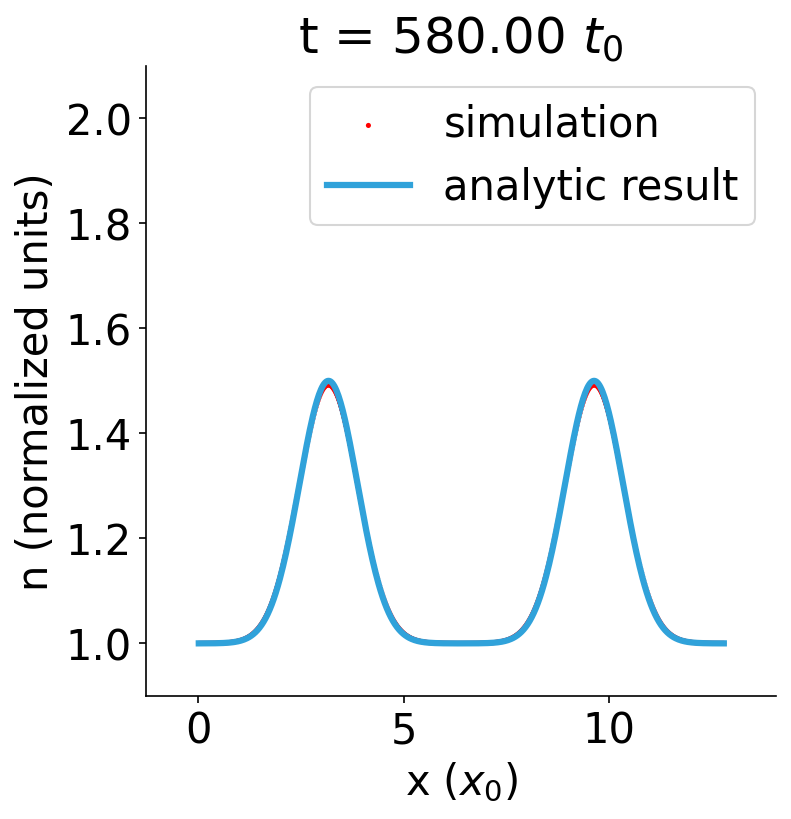
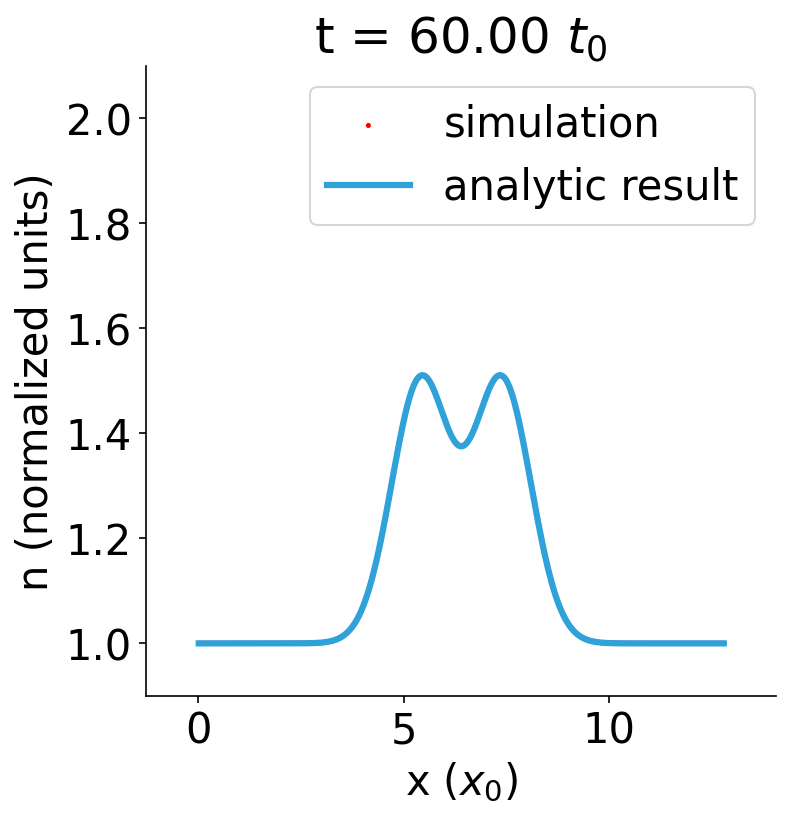
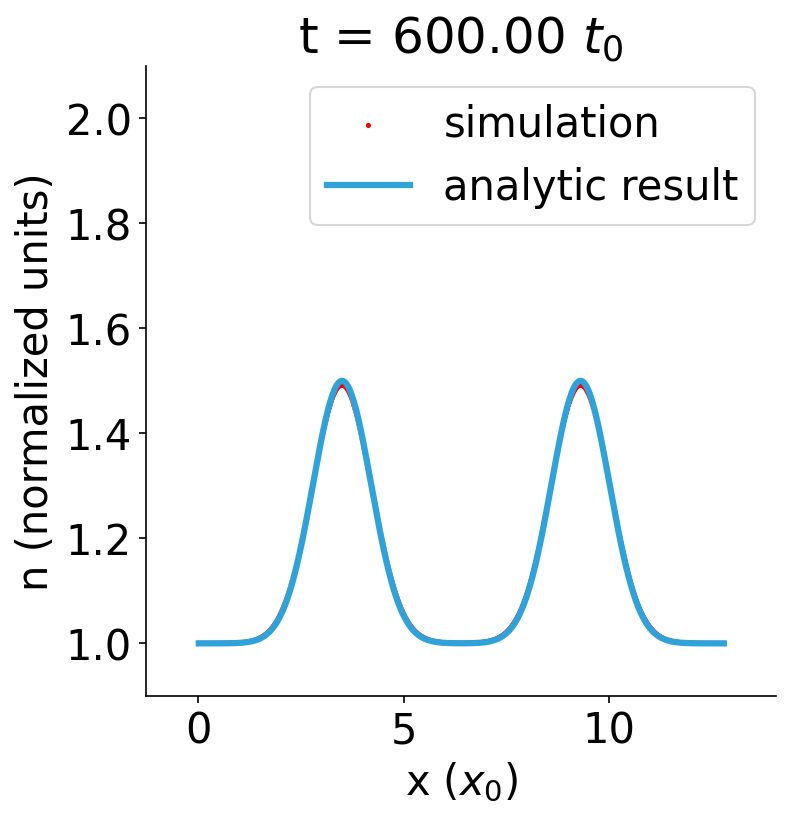
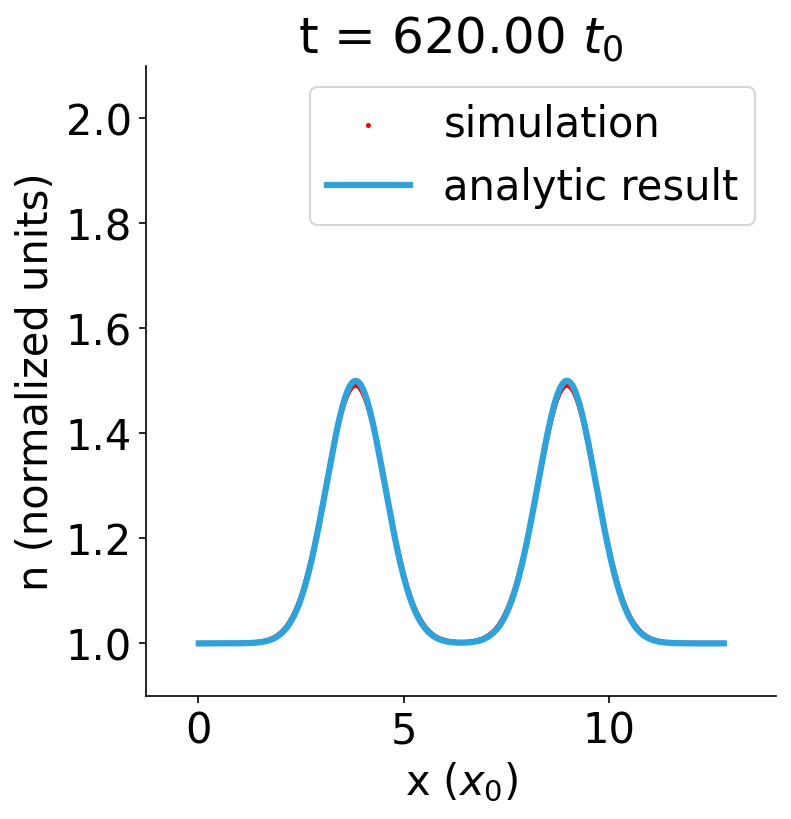
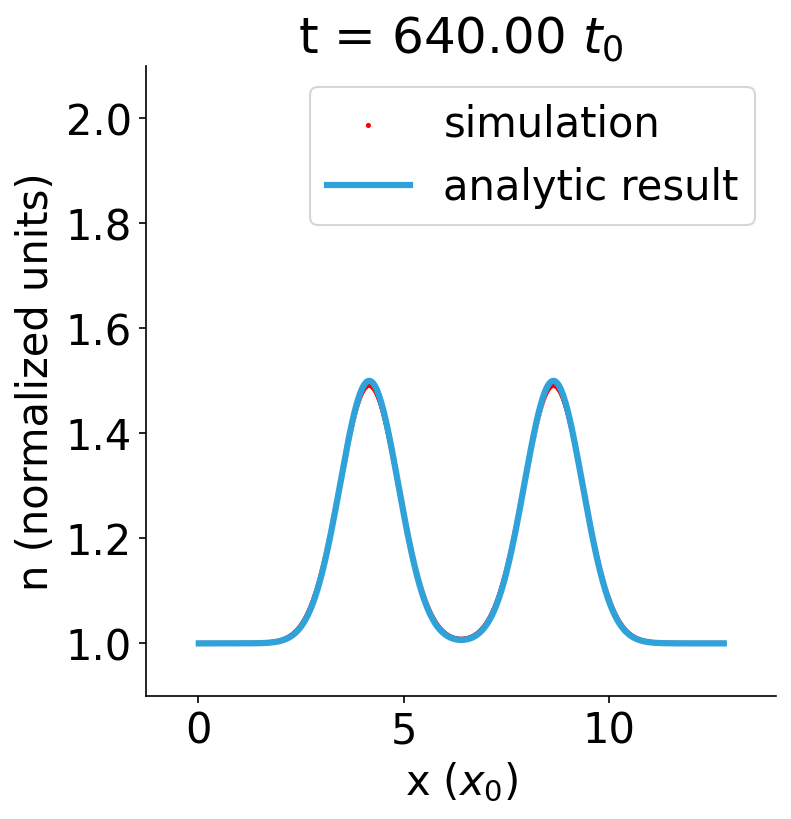
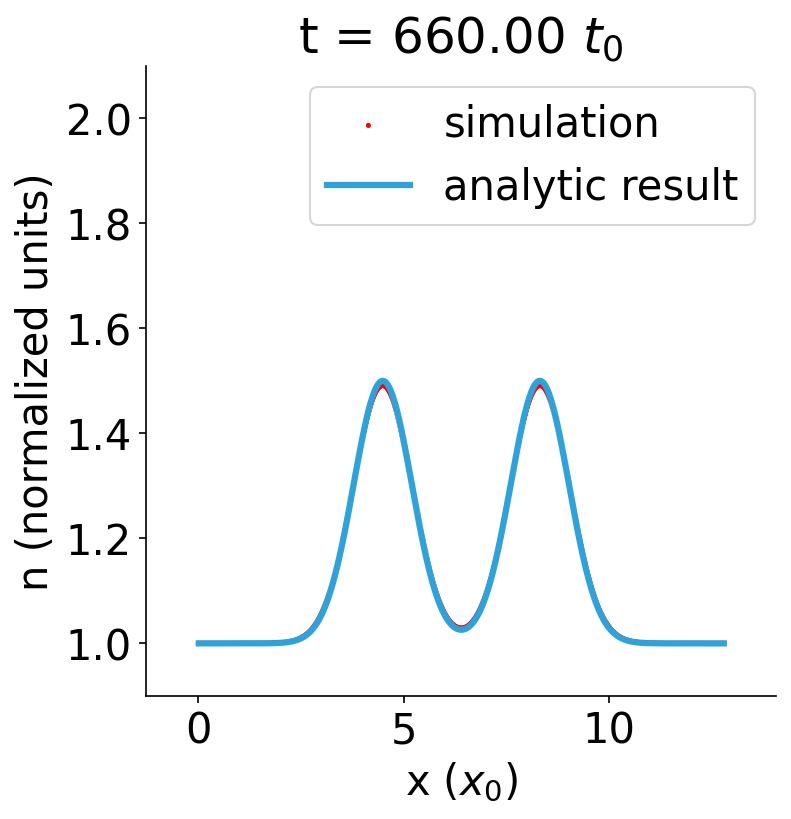
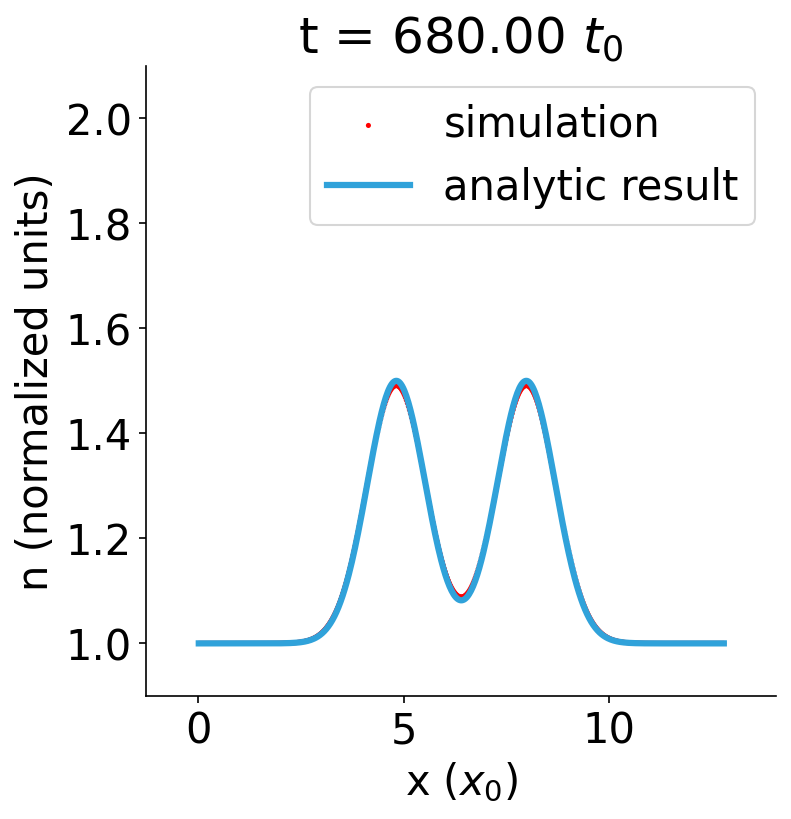
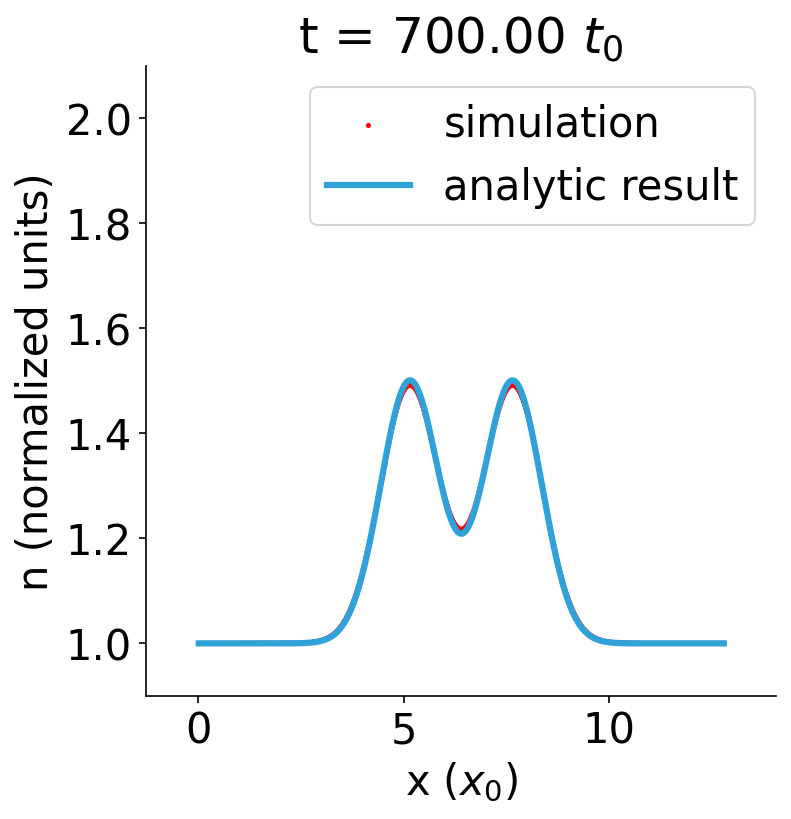
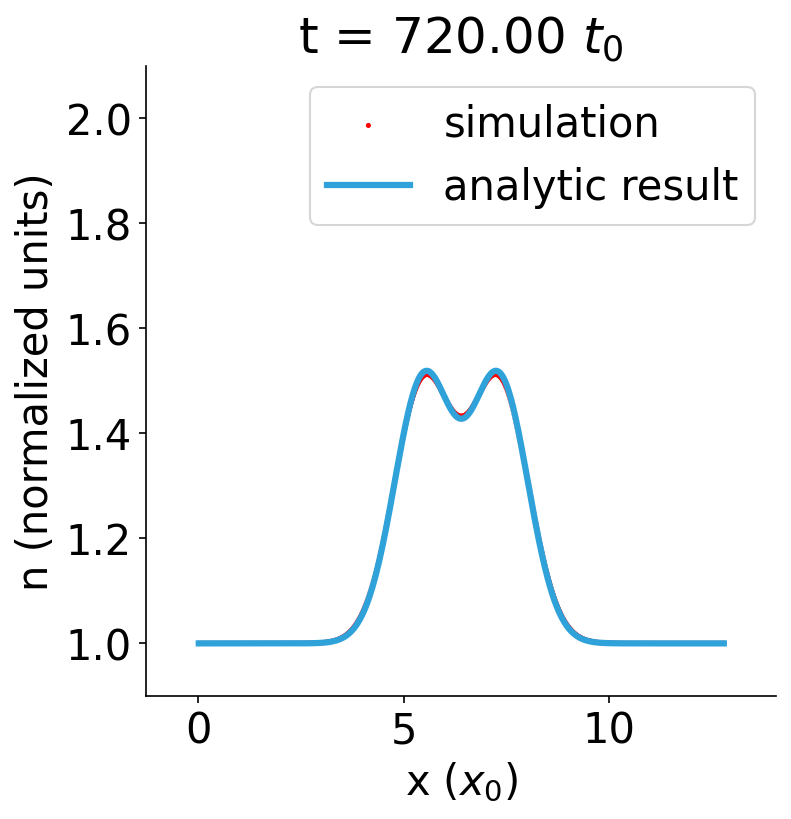
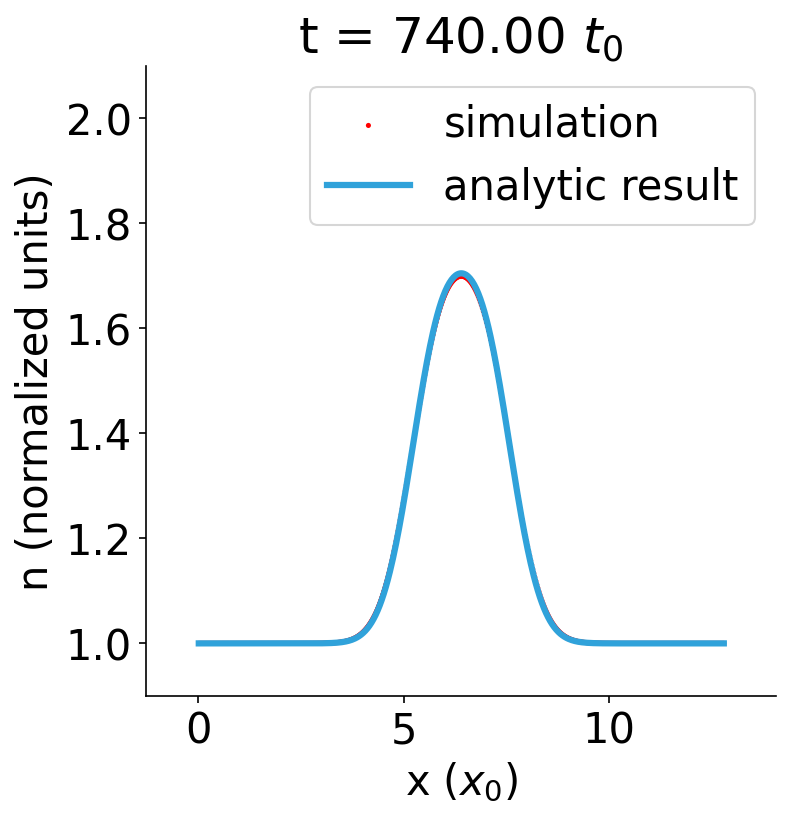
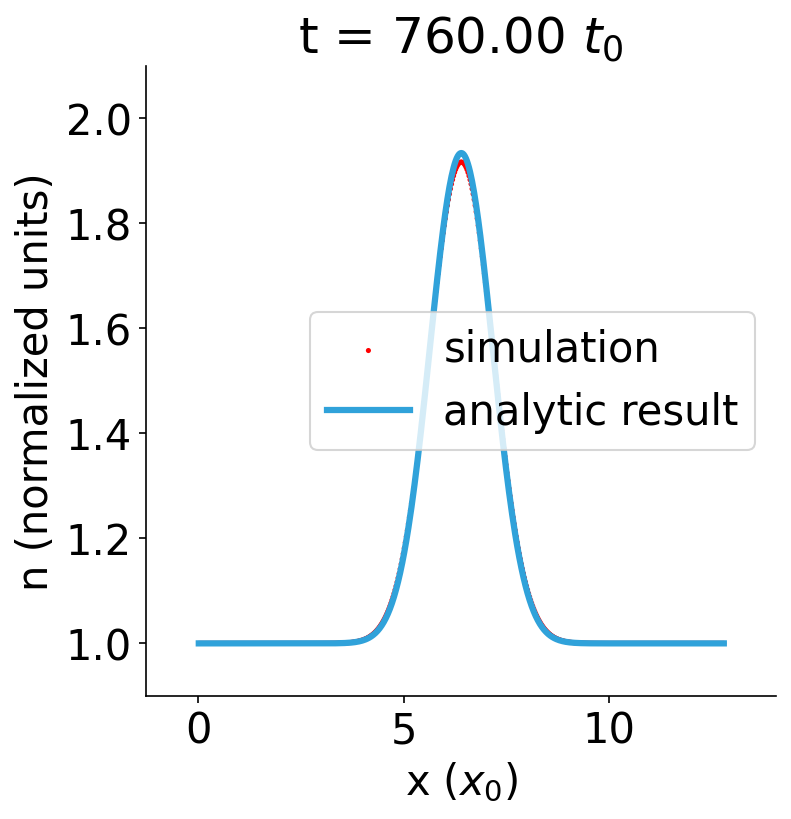
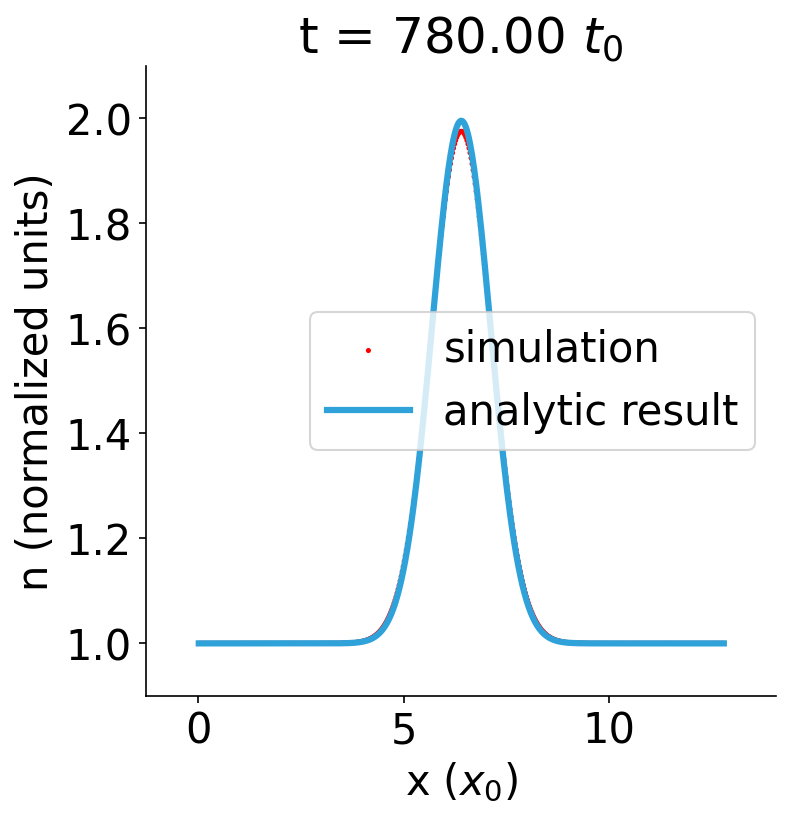
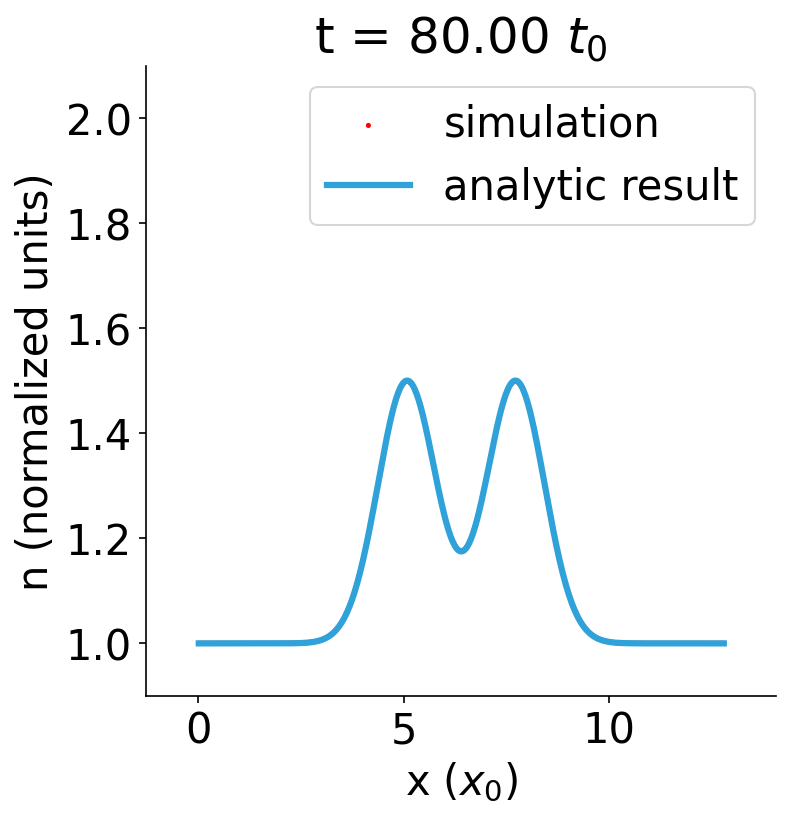
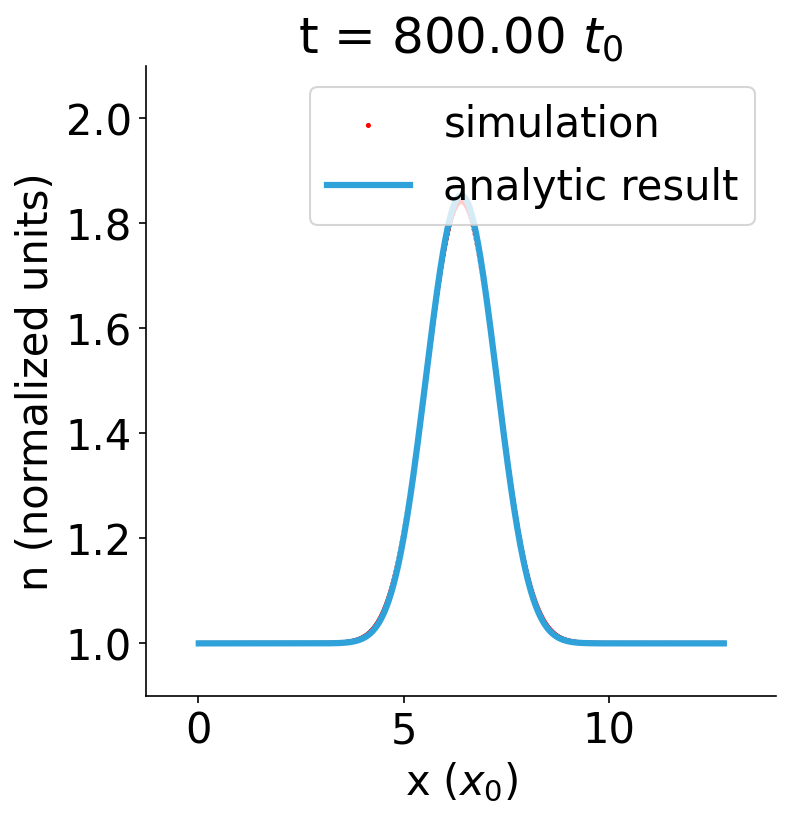
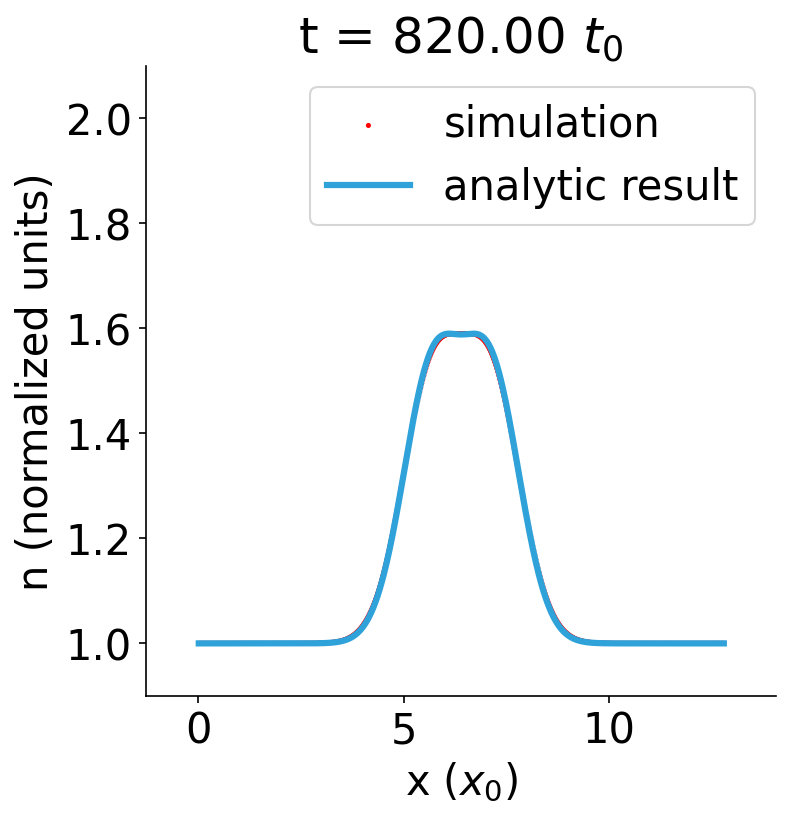
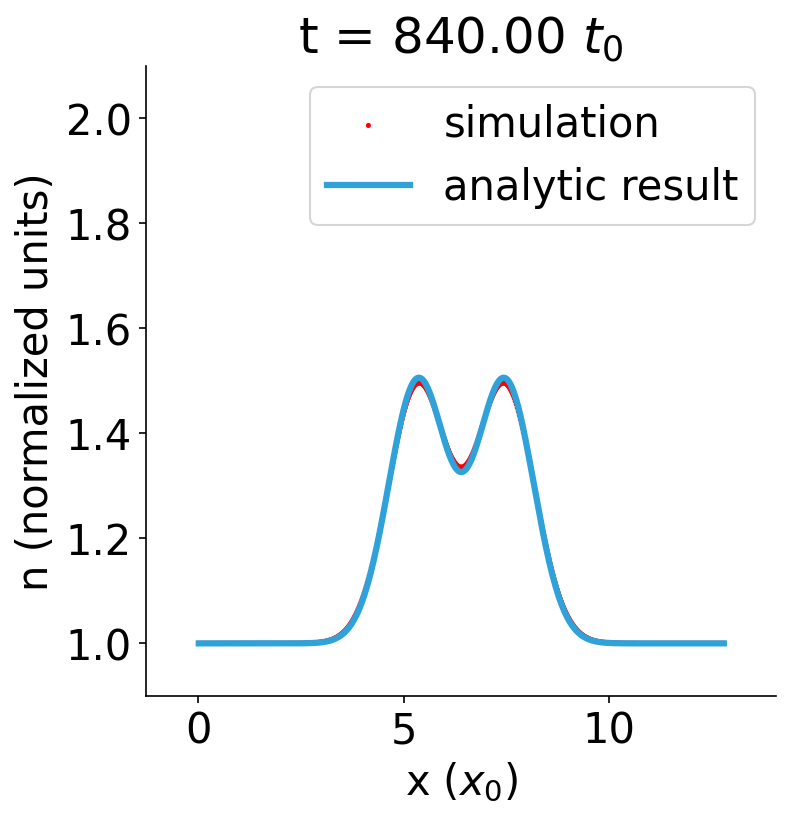
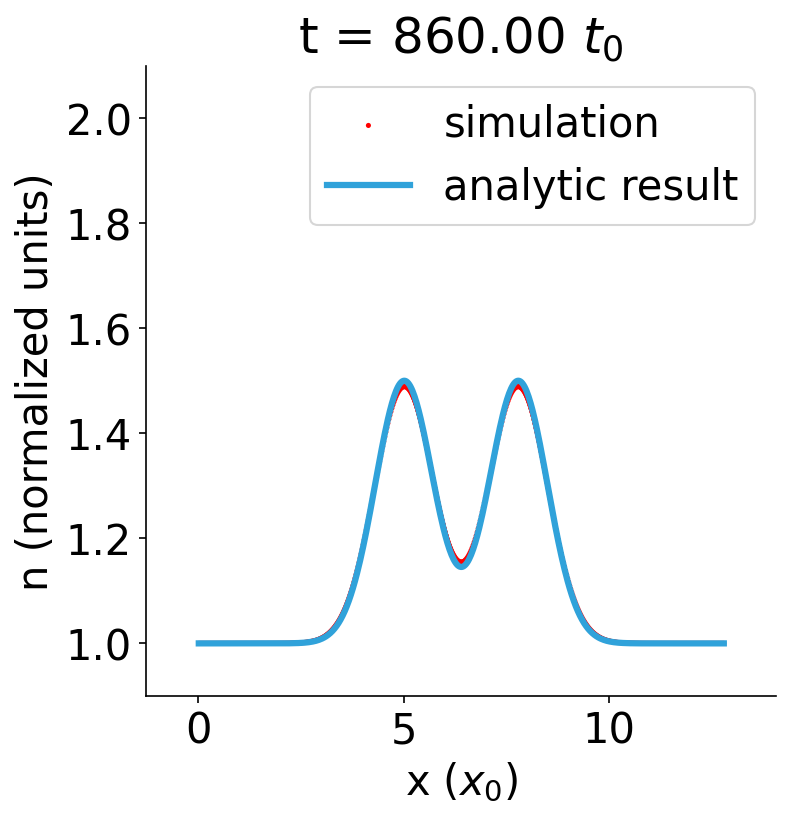
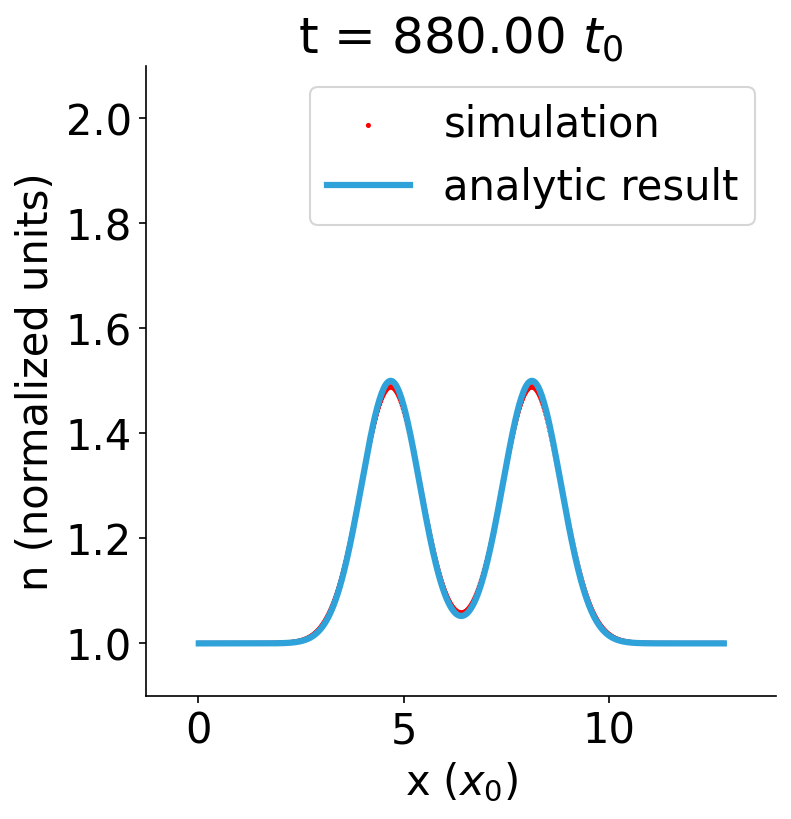
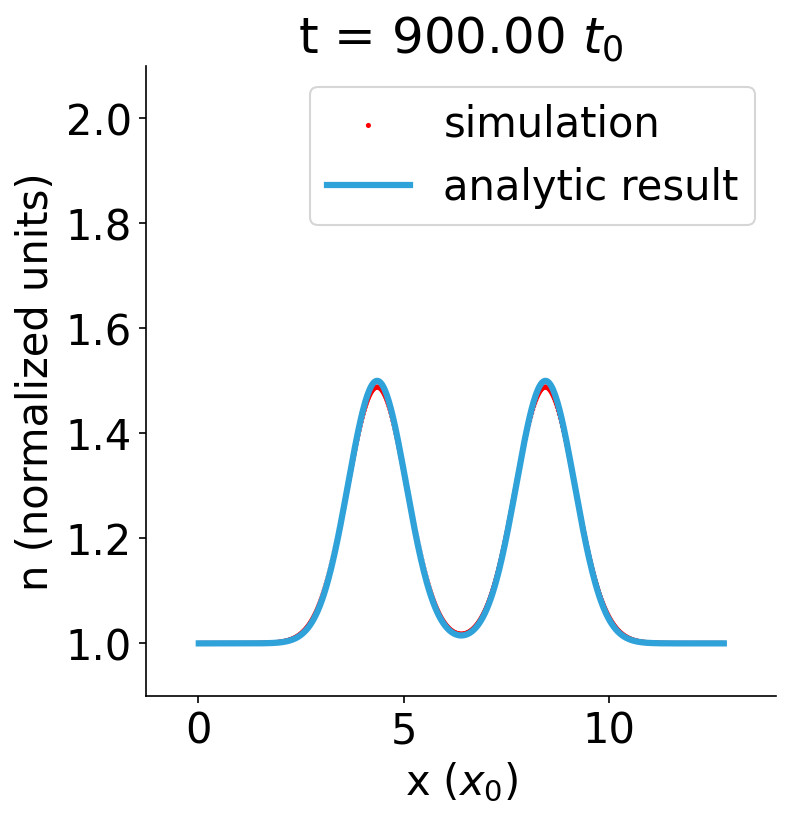
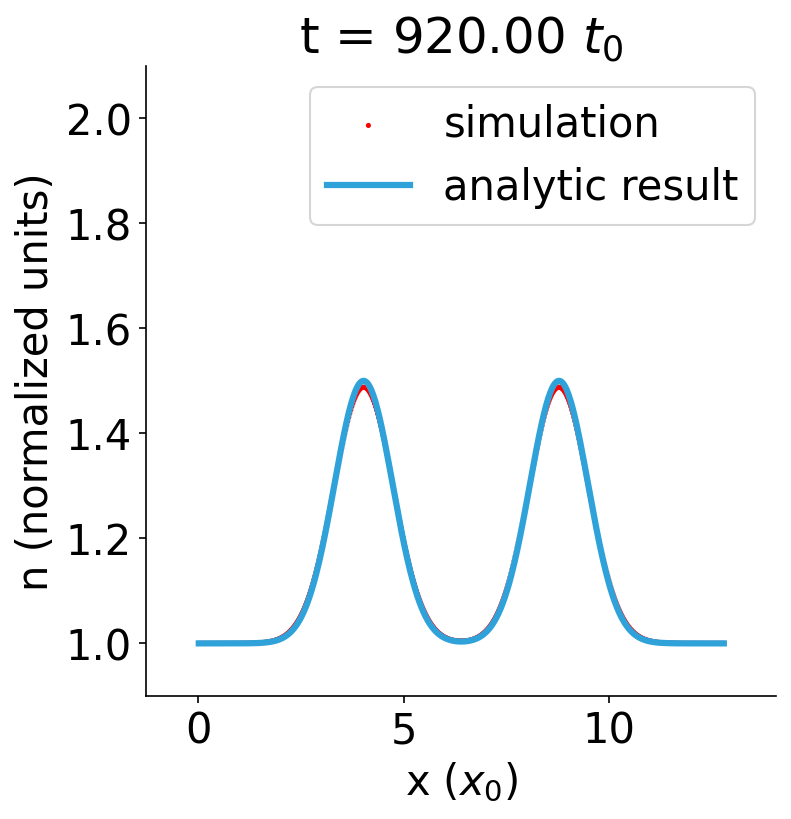
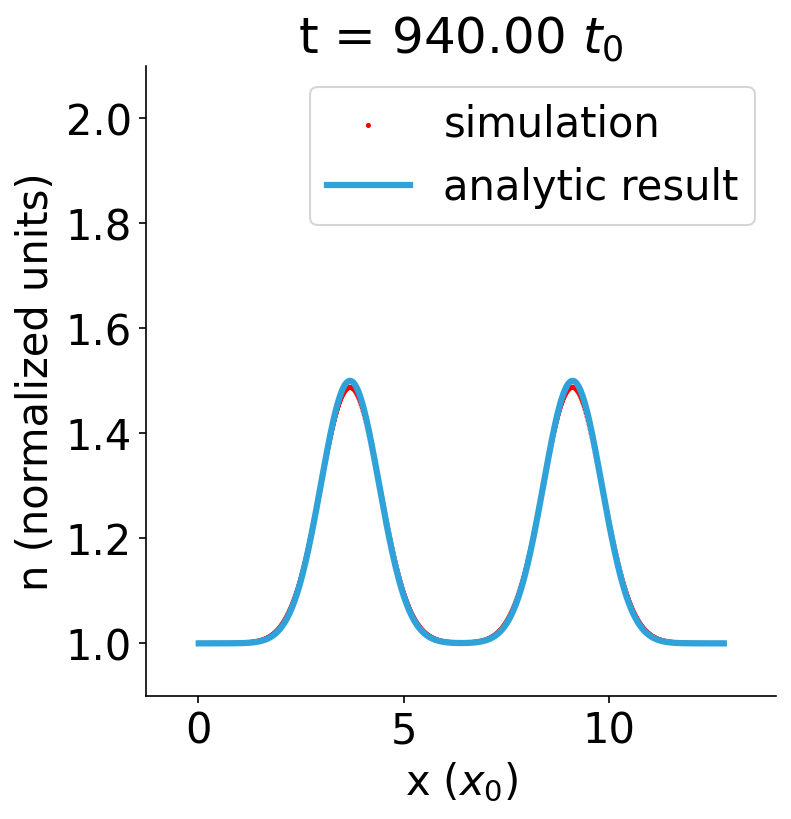
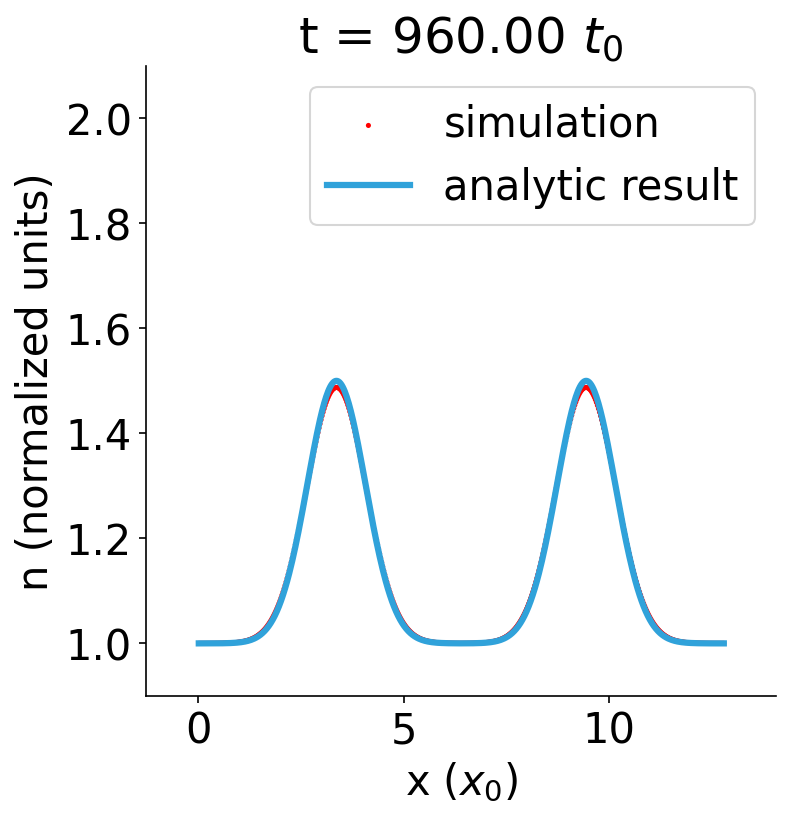
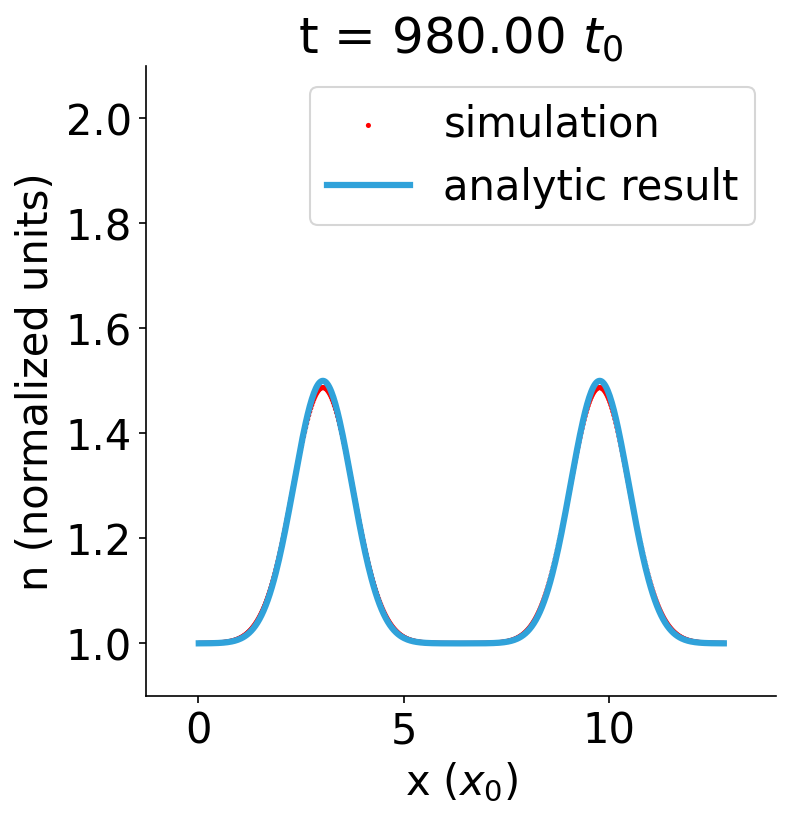
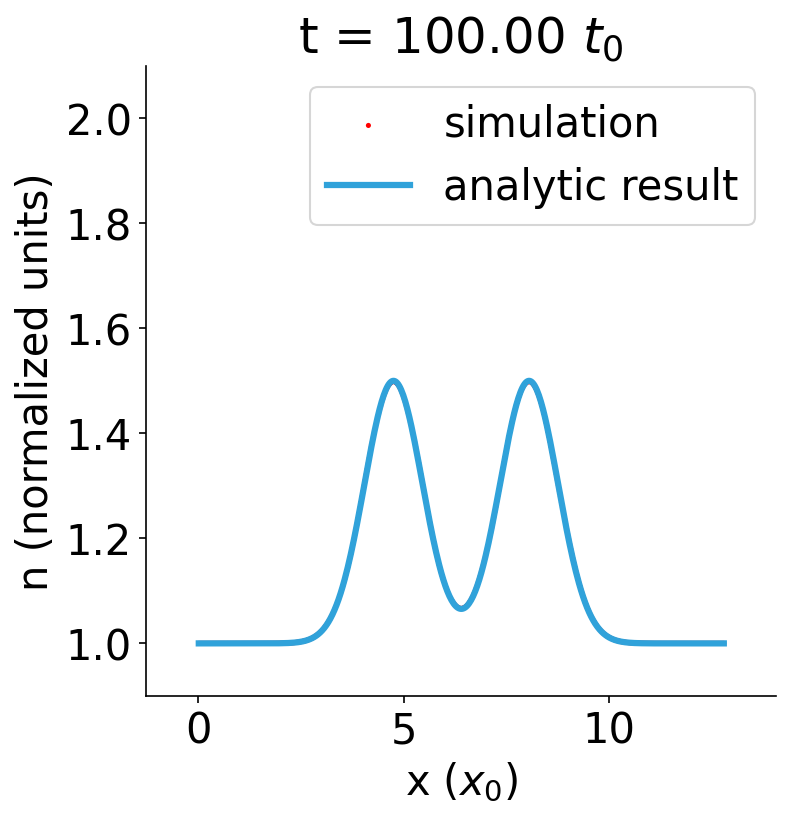
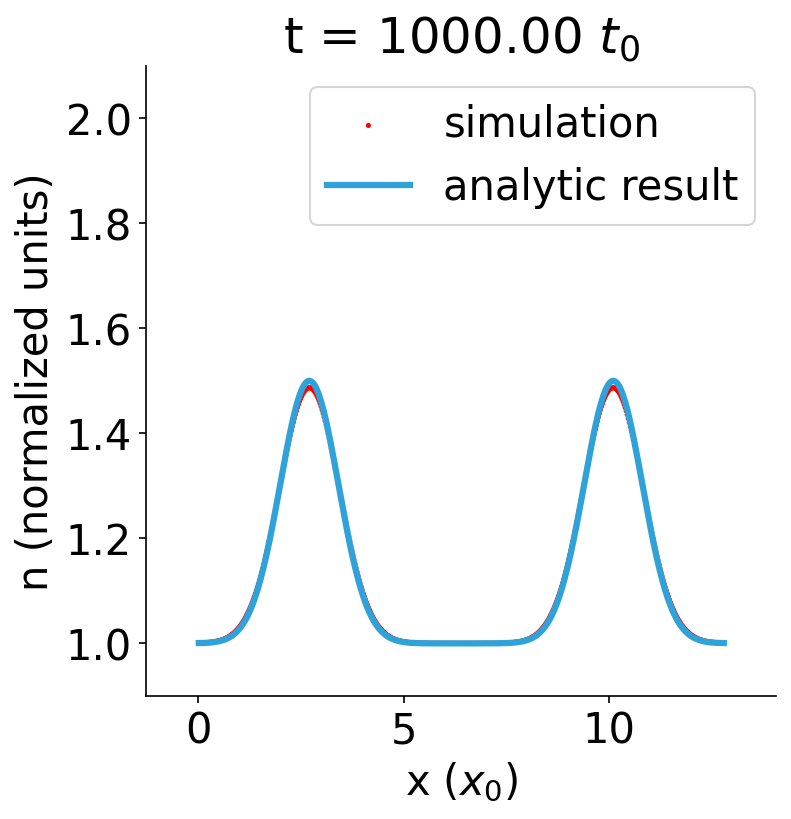
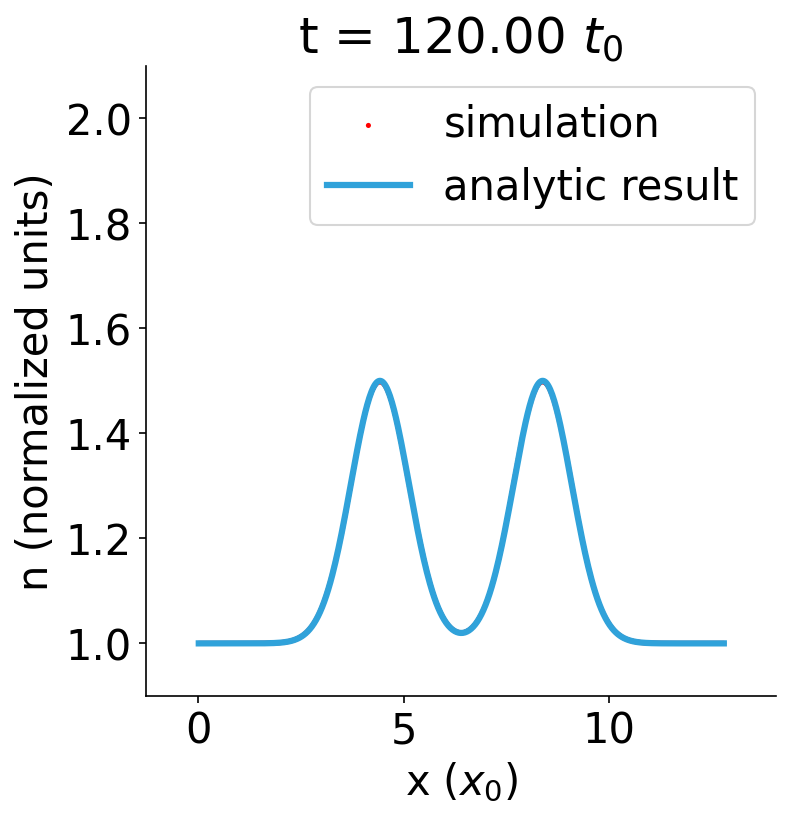
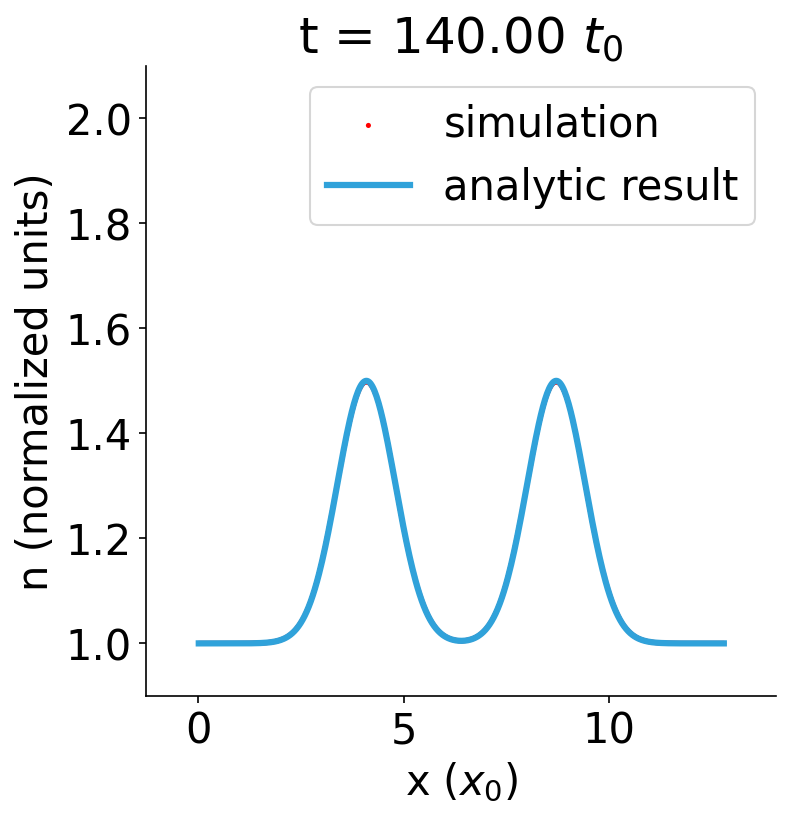
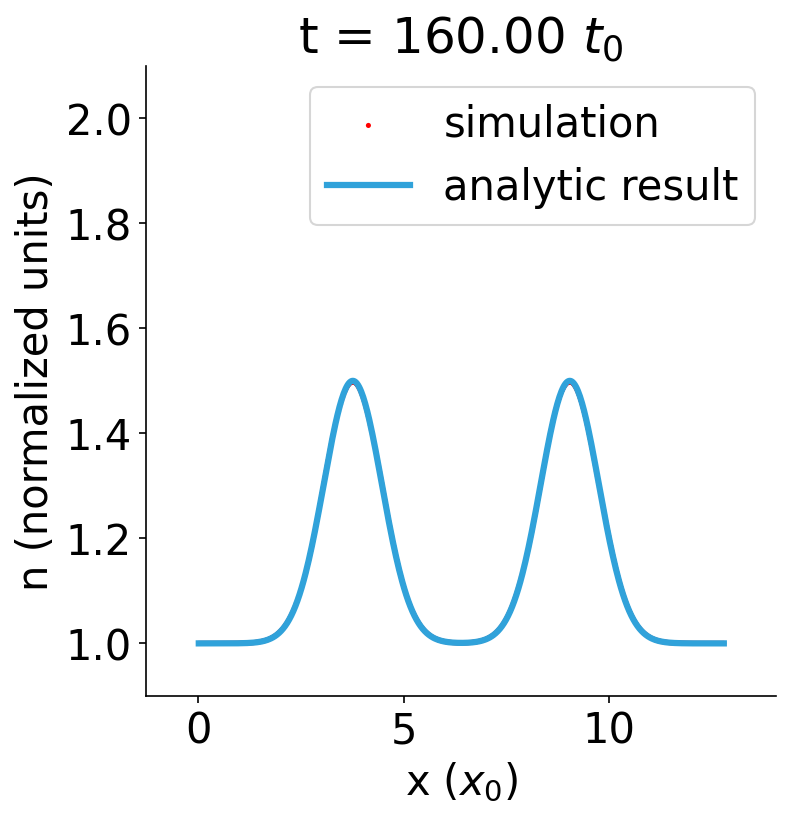
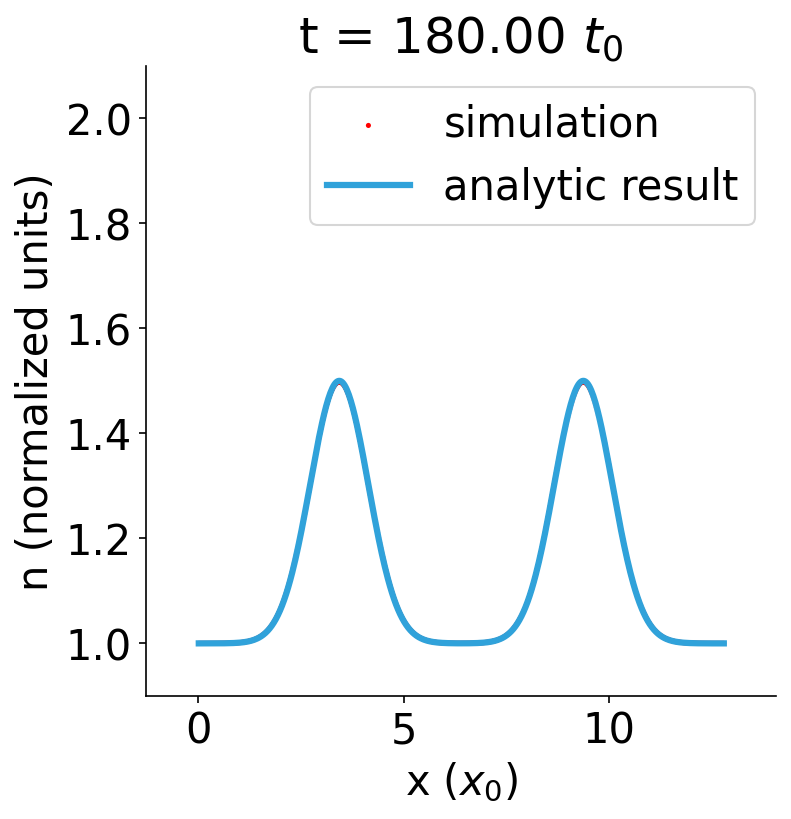
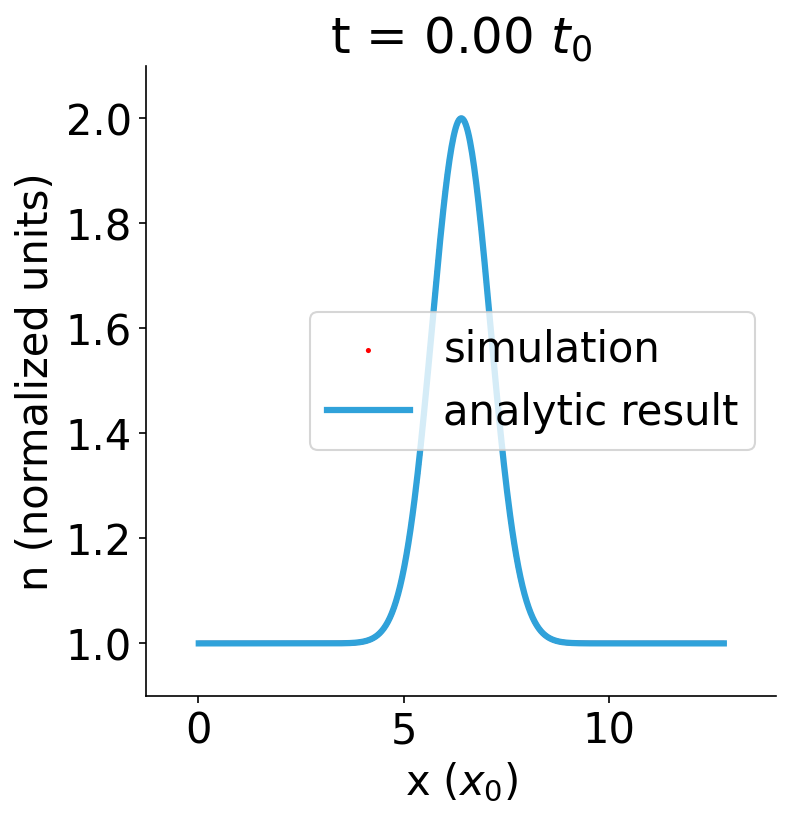

In [27]:
dataName = 'n'

curveDict = {t: hv.Scatter(loadedData[dataName][{"time":t}],label='simulation').opts(marker="o",color="r",s=6.0)*hv.Curve((gridObj.xGrid,n_analytic[t,:]),label='analytic result').opts(title=f't = {loadedData["time"].values[t]:.2f} '+loadedData.coords["time"].attrs["units"],fontscale=2, fig_size=150,linewidth=3.0) for t in range(numFiles+1)}
kdims = [hv.Dimension(('time', 'Time'),unit=loadedData.coords["time"].attrs["units"], default=0)]
hv.HoloMap(curveDict,kdims=kdims).opts()

### Check if W is calculated correctly

In [22]:
dataName = 'W'

testWCalc = loadedData['n']*loadedData['T'] * 1.5 + loadedData['u']**2 /( loadedData['n']*massRatio) - loadedData['W']

print(testWCalc.where(np.abs(testWCalc)>5e-16,drop=True))

<xarray.DataArray (time: 0, x: 0)>
array([], shape=(0, 0), dtype=float64)
Coordinates:
  * x        (x) float64 
  * time     (time) float64 


### Producing graphs for the paper

### Relative error wrt analytic solution

In [23]:
diff = np.abs(n_analytic - loadedData['n'])/n_analytic

In [24]:
relativeErrorPlot=hv.Curve(diff.reduce(np.max,'x')).opts(ylabel='$\delta n$',marker='o',fontscale=2, fig_size=150,linewidth=3.0)

:Curve   [time]   (n)
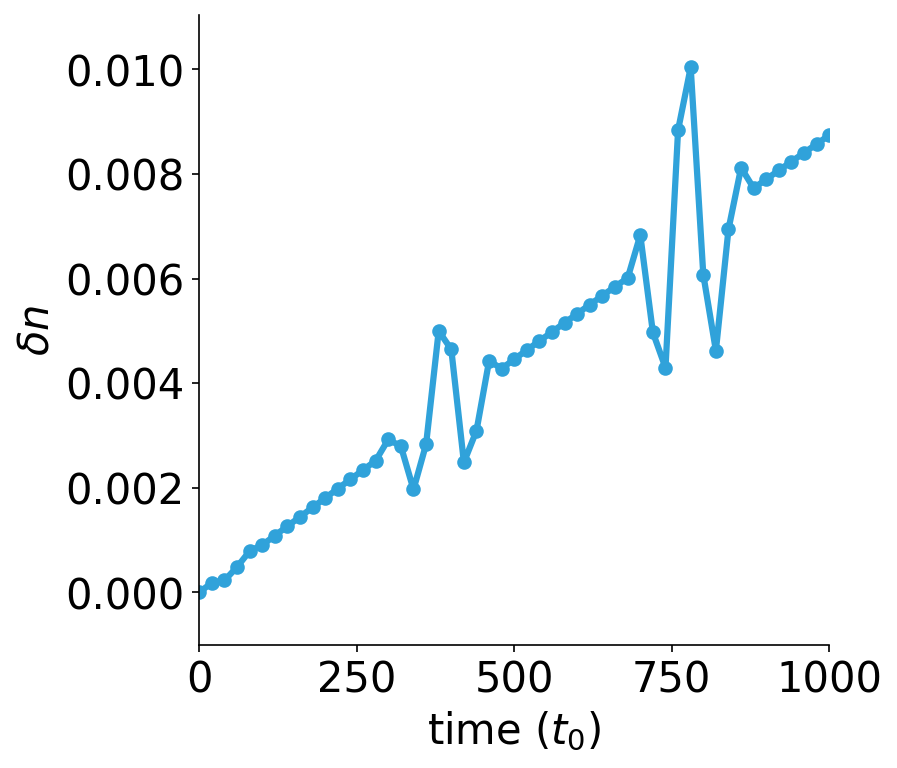

In [28]:
relativeErrorPlot.opts()

In [25]:
hv.output(fig='pdf')
hv.save(relativeErrorPlot, 'advectionTestRelErr.pdf', dpi=144)

### Final simulation state

In [26]:
hv.save(curveDict[50].opts(legend_position='top',legend_cols=1,title=''),'finalDensityAdv.pdf',dpi=144)